# WIND AND SOLAR FOR ALL EU COUNTRIES, 2015-2020, ENTSO-E
ENTSO-E data for each country containing capacity and generation for wind and solar for each European country (except North Macedonia)

In [1]:
# Importing packages
import atlite
import xarray as xr
import pandas as pd
import scipy.sparse as sp
import math  
import numpy as np
from matplotlib import dates
import datetime

import pgeocode
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline
import seaborn as sns

import requests
import os
import zipfile

import atlite
import logging
logging.basicConfig(level=logging.INFO)

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from matplotlib.gridspec import GridSpec
from atlite.gis import shape_availability, ExclusionContainer
from rasterio.plot import show
import glob
from countrygroups import EUROPEAN_UNION
from hampel import hampel
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl

# Defining figure size for maps:
map_fig_size = (10,10)
fig_size = (12,8)
turbine = "Siemens_SWT_107_3600kW"
num_years_ERA5 = 8               # number of years in ERA5 cutouts

In [2]:
# Defining plotting function: 
def plot_path(plot_filename):
    plot_path = f'Figures/{plot_filename}'
    return plot_path

In [3]:
# import warnings
# import logging

# warnings.simplefilter("always", DeprecationWarning)
# logging.captureWarnings(True)
# logging.basicConfig(filename="example.log", level=logging.DEBUG)

In [4]:
# Creating custom color map range to enable transparent background outside country borders

# get colormap
ncolors = 256
color_array = plt.get_cmap('Greens')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='green_alpha',colors=color_array)

# register this new colormap with matplotlib (needs to be run once after opening the document)
plt.matplotlib.colormaps.register(cmap=map_object)

Creating a function that will download data from url and save it.

In [5]:
# Defining function that helps download date from an url that downloads a .csv file
def download_file(url, local_filename):
    # variant of http://stackoverflow.com/a/16696317
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return local_filename

Downloading data from ENTSO-E using https://data.open-power-system-data.org/
(Download and then go into downloads in chrome and copy link)

In [6]:
# Adding non-EU countries to the list of countries

#others = (["Switzerland","Czech Republic", "Ukraine","Moldova", "Serbia","Albania", "United Kingdom", 
#           "Montenegro","Bosnia and Herzegovina","North Macedonia","Kosovo","Norway"])
others = (["Switzerland","Czech Republic", "Serbia","Albania", "United Kingdom", 
           "Montenegro","Bosnia and Herzegovina","North Macedonia","Kosovo","Norway"])
europe_list = EUROPEAN_UNION.names + others
europe_list.remove("Czechia")
europe_list.sort()
print(europe_list)

['Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom']


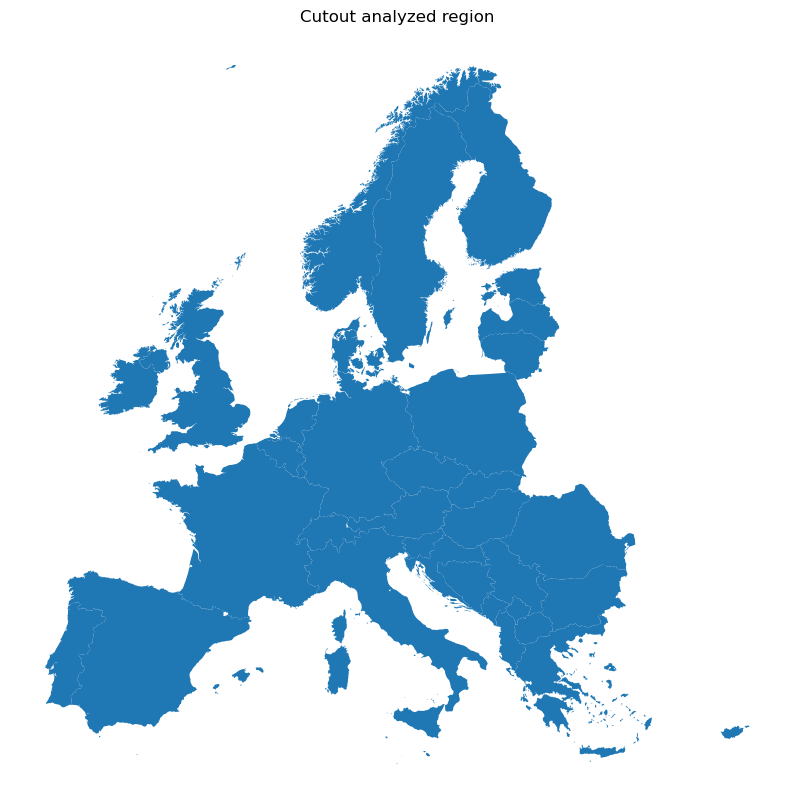

In [7]:
# Defining shape of European countries

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
Europe = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs="epsg:4326",
).reindex(europe_list)

# Removing extra territories (islands in the Atlantic, etc.)
mask = (-11, 30, 50, 74)
Europe = Europe.clip(mask)
projection = ccrs.Orthographic(10, 35)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
Europe.plot(ax=ax,transform=plate(),aspect='equal').set_frame_on(False)
plt.grid()
plt.title('Cutout analyzed region');

In [9]:
# Importing cutouts from external HDD

bounds = Europe.unary_union.buffer(1).bounds

Europe_era5_15 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_15.nc", module="era5", bounds=bounds, time=slice("2015-01-01", "2015-12-31"))
Europe_era5_16 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_16.nc", module="era5", bounds=bounds, time=slice("2016-01-01", "2016-12-31"))
Europe_era5_17 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_17.nc", module="era5", bounds=bounds, time=slice("2017-01-01", "2017-12-31"))
Europe_era5_18 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_18.nc", module="era5", bounds=bounds, time=slice("2018-01-01", "2018-12-31"))
Europe_era5_19 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_19.nc", module="era5", bounds=bounds, time=slice("2019-01-01", "2019-12-31"))
Europe_era5_20 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_20.nc", module="era5", bounds=bounds, time=slice("2020-01-01", "2020-12-31"))
Europe_era5_21 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_21.nc", module="era5", bounds=bounds, time=slice("2021-01-01", "2021-12-31"))
Europe_era5_22 = atlite.Cutout(
    path="C://Users/c10si/Cutouts/Europe_era5_22.nc", module="era5", bounds=bounds, time=slice("2022-01-01", "2022-12-31"))

# Europe_era5_18_20 = atlite.Cutout(
#     path="E:\\Cutouts\\Europe_era5_18_20.nc", module="era5", bounds=bounds, time=slice("2018-01-01", "2020-12-31"))

c:\Users\c10si\anaconda3\envs\Pre-project_environment_2_20230\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(
c:\Users\c10si\anaconda3\envs\Pre-project_environment_2_20230\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(
c:\Users\c10si\anaconda3\envs\Pre-project_environment_2_20230\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(
c:\Users\c10si\anaconda3\envs\Pre-project_environment_2_20230\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(
c:\Users\c10si\anaconda3\envs\Pre-project_environment_2_20230\lib\site-packages\atlite\cutout.py:194: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(
c:\Users\c

In [10]:
# Europe_era5_15.prepare();
# Europe_era5_16.prepare();

## Merging cutouts together

In [11]:
# Europe_era5_18_19 = Europe_era5_18.merge(Europe_era5_19, path="E:\\Cutouts\\Europe_era5_18_19.nc")
# Europe_era5_18_19.prepare()

In [12]:
# Europe_era5_18_20 = Europe_era5_18_19.merge(Europe_era5_20, path="E:\\Cutouts\\Europe_era5_18_20.nc")
# Europe_era5_18_20.prepare()

In [13]:
# Europe_era5_18_21 = Europe_era5_18_20.merge(Europe_era5_21, path="E:\\Cutouts\\Europe_era5_18_21.nc")
# Europe_era5_18_21.prepare()

In [14]:
# Saving merged cutout to file
# Europe_era5_18_20.to_file()

In [15]:
# Europe_era5_21_22 = Europe_era5_21.merge(Europe_era5_22, path="E:\\Cutouts\\Europe_era5_21_22.nc")
# Europe_era5_21_22.prepare()

# Saving merged cutout to file
# Europe_era5_21_22.to_file()

In [16]:
# Saving merged cutout to file
# Europe_era5_18_22.to_file()

# Giving the final cutout a name: 
ERA5_final_cutout = Europe_era5_22;

In [17]:
Europe_era5_15.data["wnd100m"].mean()

<xarray.DataArray 'wnd100m' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [18]:
# fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
# cap_factors_PV.name = "Capacity Factor PV"
# cap_factors_PV.plot(ax=ax, transform=plate(), alpha=0.9,cmap="Reds",
#                     cbar_kwargs={'shrink': 0.7, 'aspect': 40})
# Europe.plot(ax=ax, transform=plate(), edgecolor="k", color="None",aspect="equal",).set_frame_on(False);
# cells.plot(ax=ax, **plot_grid_dict)
# ax.spines['geo'].set_edgecolor('white')
# fig.tight_layout();
# ax.set_title('Average capacity factor for PV over 8 years');

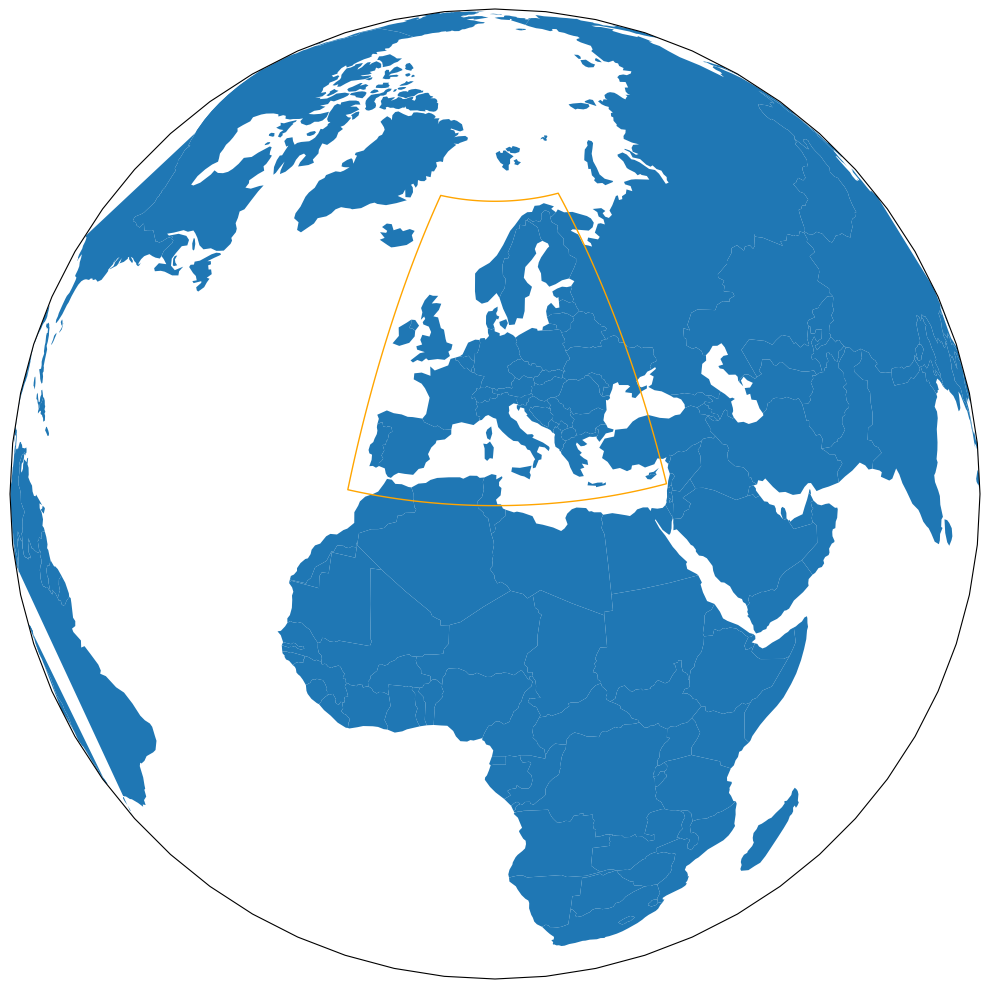

In [19]:
cells = ERA5_final_cutout.grid
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.Orthographic(10, 35)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
plt.grid()
fig.tight_layout()

In [20]:
# # Generating average CF per year for wind:
# CF_avg_wind_15 = Europe_era5_15.wind(turbine=turbine,capacity_factor=True)
# CF_avg_wind_16 = Europe_era5_16.wind(turbine=turbine,capacity_factor=True)
# CF_avg_wind_17 = Europe_era5_17.wind(turbine=turbine,capacity_factor=True)
# CF_avg_wind_18 = Europe_era5_18.wind(turbine=turbine, capacity_factor=True)
# CF_avg_wind_19 = Europe_era5_18.wind(turbine=turbine, capacity_factor=True)
# CF_avg_wind_20 = Europe_era5_18.wind(turbine=turbine, capacity_factor=True)
# CF_avg_wind_21 = Europe_era5_21.wind(turbine=turbine, capacity_factor=True)
# CF_avg_wind_22 = Europe_era5_22.wind(turbine=turbine,capacity_factor=True)

# # Saving to files: 
# CF_avg_wind_15.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_15.nc")
# CF_avg_wind_16.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_16.nc")
# CF_avg_wind_17.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_17.nc")
# CF_avg_wind_18.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_18.nc")
# CF_avg_wind_19.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_19.nc")
# CF_avg_wind_20.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_20.nc")
# CF_avg_wind_21.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_21.nc")
# CF_avg_wind_22.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_wind_22.nc")


In [ ]:
# Load average CF for wind:
CF_avg_wind_15 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_15.nc")
CF_avg_wind_16 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_16.nc")
CF_avg_wind_17 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_17.nc")
CF_avg_wind_18 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_18.nc")
CF_avg_wind_19 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_19.nc")
CF_avg_wind_20 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_20.nc")
CF_avg_wind_21 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_21.nc")
CF_avg_wind_22 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_wind_22.nc")

In [ ]:
# Average CF for onshore wind (for layout)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
    )

# cap_factors = ERA5_final_cutout.wind(turbine=turbine, capacity_factor=True)

cap_factors = (1/num_years_ERA5)*(CF_avg_wind_15
                                  +CF_avg_wind_16
                                  +CF_avg_wind_17
                                  +CF_avg_wind_18
                                  +CF_avg_wind_19
                                  +CF_avg_wind_20
                                  +CF_avg_wind_21
                                  +CF_avg_wind_22
                     )
# fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
# cap_factors.name = "Capacity Factor"
# cap_factors.plot(ax=ax, transform=plate(), alpha=0.9)
# cells.plot(ax=ax, **plot_grid_dict)
# ax.spines['geo'].set_edgecolor('None')
# fig.tight_layout();
# ax.set_title('Average capacity factor for onshore wind over 8 years');

In [ ]:
# # Generating average CF per year for PV:
# CF_avg_PV_15 = Europe_era5_15.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)
# CF_avg_PV_16 = Europe_era5_16.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)
# CF_avg_PV_17 = Europe_era5_17.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)
# CF_avg_PV_18 = Europe_era5_18.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)
# CF_avg_PV_19 = Europe_era5_19.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)
# CF_avg_PV_20 = Europe_era5_20.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)
# CF_avg_PV_21 = Europe_era5_21.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)
# CF_avg_PV_22 = Europe_era5_22.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",capacity_factor=True)

# # Saving to files: 
# CF_avg_PV_15.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_15.nc")
# CF_avg_PV_16.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_16.nc")
# CF_avg_PV_17.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_17.nc")
# CF_avg_PV_18.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_18.nc")
# CF_avg_PV_19.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_19.nc")
# CF_avg_PV_20.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_20.nc")
# CF_avg_PV_21.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_21.nc")
# CF_avg_PV_22.to_netcdf(path="E://Cutouts/Annual average CF per cell/CF_avg_PV_22.nc")


In [ ]:
# Load average CF for PV:
CF_avg_PV_15 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_15.nc")
CF_avg_PV_16 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_16.nc")
CF_avg_PV_17 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_17.nc")
CF_avg_PV_18 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_18.nc")
CF_avg_PV_19 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_19.nc")
CF_avg_PV_20 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_20.nc")
CF_avg_PV_21 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_21.nc")
CF_avg_PV_22 = xr.open_dataarray("E://Cutouts/Annual average CF per cell/CF_avg_PV_22.nc")

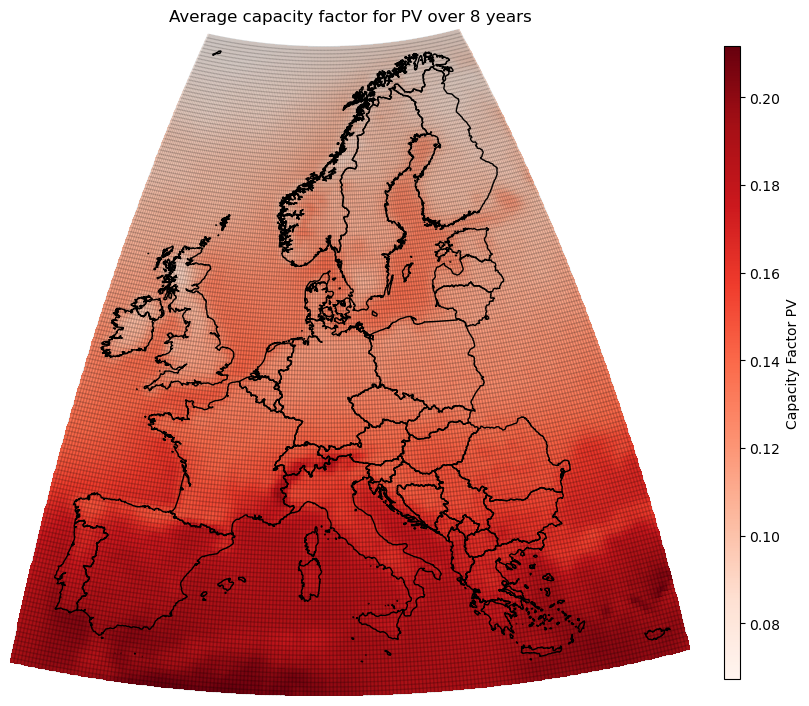

In [ ]:
# Average CF over 8 years for PV (for layout)

# cap_factors = ERA5_final_cutout.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", capacity_factor=True)

cap_factors_PV = (1/num_years_ERA5)*(CF_avg_PV_15
                                  +CF_avg_PV_16
                                  +CF_avg_PV_17
                                  +CF_avg_PV_18
                                  +CF_avg_PV_19
                                  +CF_avg_PV_20
                                  +CF_avg_PV_21
                                  +CF_avg_PV_22
                                    )

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8,8),layout='constrained')
cap_factors_PV.name = "Capacity Factor PV"
cap_factors_PV.plot(ax=ax, transform=plate(),cmap="Reds",
                    cbar_kwargs={'shrink': 0.8, 'aspect': 40})
Europe.plot(ax=ax, transform=plate(), edgecolor="k", color="None",aspect="equal",).set_frame_on(False);
cells.plot(ax=ax, **plot_grid_dict)
ax.spines['geo'].set_edgecolor('white')
title = f'Average capacity factor for PV over 8 years';
ax.set_title(title);
# fig.tight_layout();

# Saving figure to file: 
plot_filename = (f'{title}.png')
plt.savefig(plot_path(plot_filename), dpi=300)

In [ ]:
# # Calculating indicator matrix - land only

# indicator_matrix_ir_sum = 0
# for i in range(len(europe_list)):
#     # country = Europe_useful.loc[[i]].geometry.to_crs(excluder.crs)
#     indicator_matrix_ir = Europe_era5_16.indicatormatrix(Europe)[i]

#     indicator_matrix_ir = xr.DataArray(indicator_matrix_ir.toarray().reshape(Europe_era5_16.shape),
#                                 #    dims=['lat','lon'],
#                                    dims=['y','x'],
#                                    coords=[Europe_era5_16.coords['lat'], Europe_era5_16.coords['lon']])
#     # fig1 = indicator_matrix_ir.plot(cmap="green_alpha", ax=ax)
#     indicator_matrix_ir_sum = indicator_matrix_ir_sum + indicator_matrix_ir;

# # Saving indicator matrix to file:
# indicator_matrix_ir_sum.to_netcdf(path="E://Cutouts/indicator_matrix_ir_sum.nc")

In [ ]:
# Loading indicator matrix from file:
indicator_matrix_ir_sum = xr.open_dataarray("E://Cutouts/indicator_matrix_ir_sum.nc")

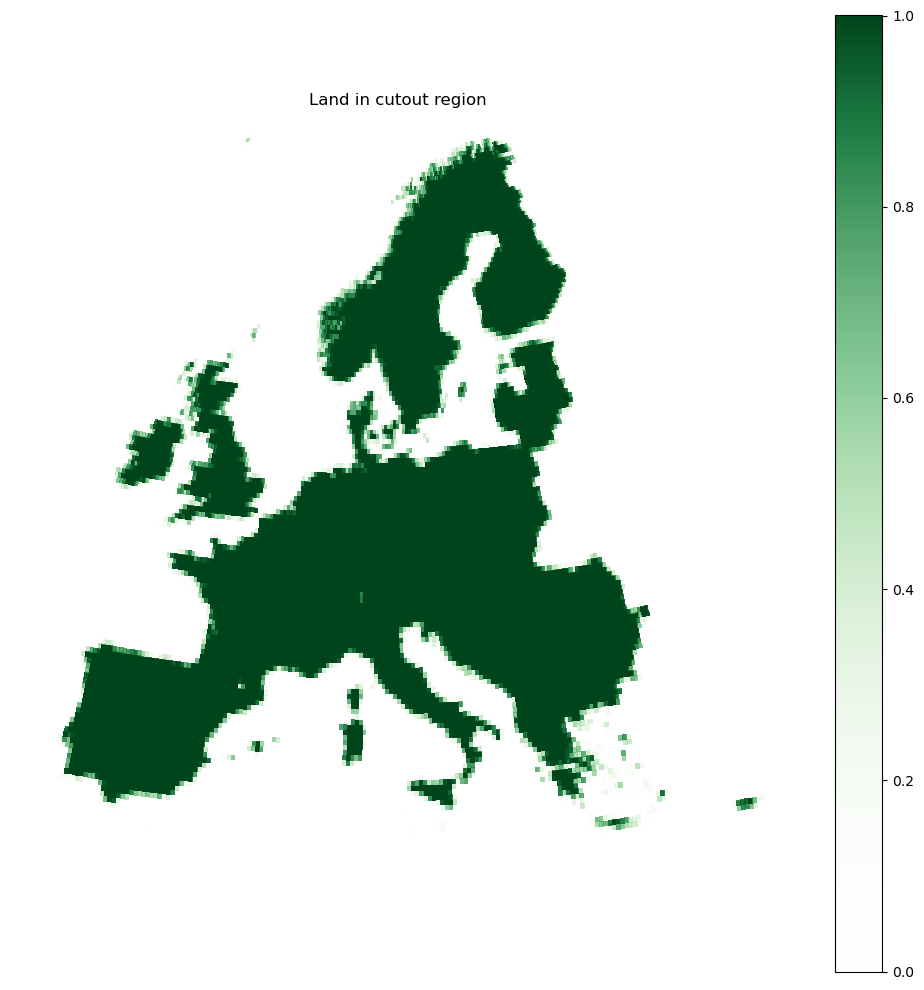

In [ ]:
# Plotting indicator matrix - showing land only
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
indicator_matrix_ir_sum.plot(cmap="green_alpha", transform=plate(), ax=ax)
fig.tight_layout()
ax.spines['geo'].set_edgecolor('white')
ax.set_title('Land in cutout region');

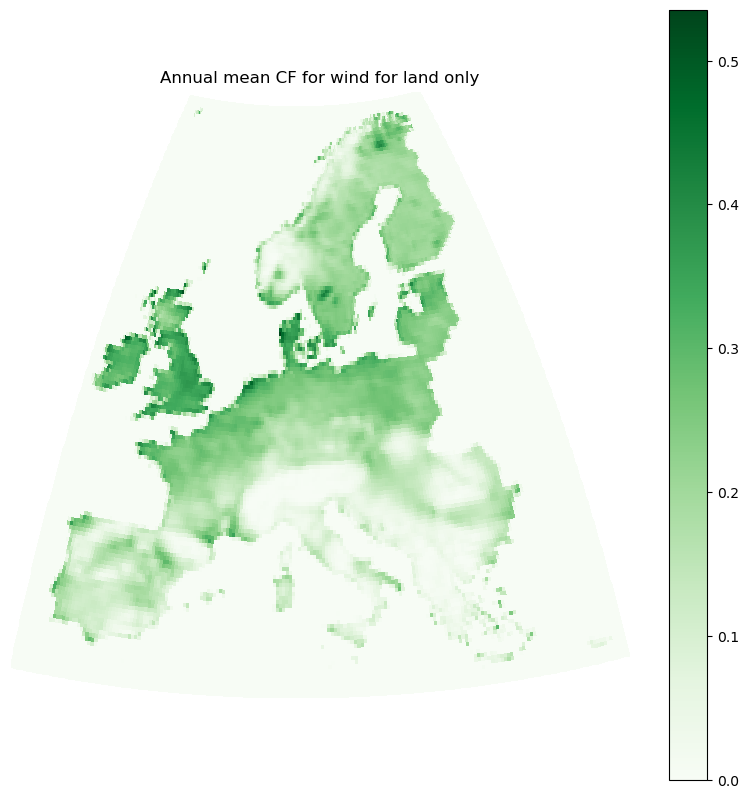

In [ ]:
# Plotting wind CF for land only
CF_land_only_wind = indicator_matrix_ir_sum*cap_factors;

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
CF_land_only_wind.plot(cmap="Greens", 
                transform=plate(), 
                # legend=False, 
                ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('white')
ax.set_title('Annual mean CF for wind for land only');

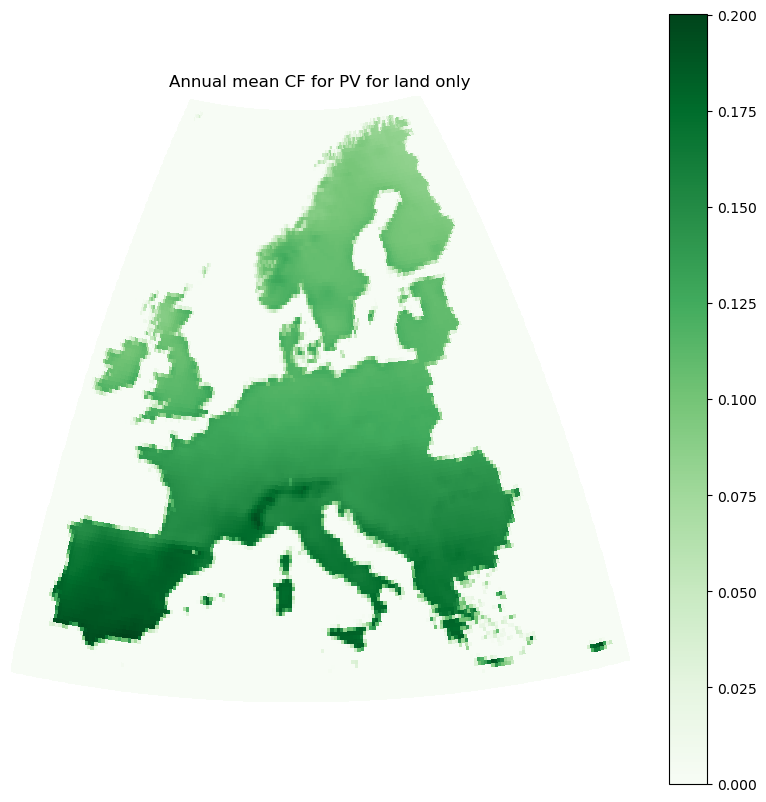

In [ ]:
# Plotting solar CF for land only
CF_land_only_PV = indicator_matrix_ir_sum*cap_factors_PV;

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
CF_land_only_PV.plot(cmap="Greens", 
                transform=plate(), 
                # legend=False, 
                ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('white')
ax.set_title('Annual mean CF for PV for land only');

In [ ]:
# # Create aggregated time-series for wind with uniform distribution
# cf_exponent=0
# layout_wind=(CF_land_only_wind**cf_exponent)*indicator_matrix_ir_sum
# total_capacity_layout=layout_wind.values.sum()
# agg_cf_wind = (1/total_capacity_layout)*Europe_era5_18_20.wind(turbine=turbine, layout=layout_wind).to_pandas()
# fig, ax = plt.subplots(1, figsize=(9, 5))
# agg_cf_wind.plot.area(ax=ax)

# ax.text(0.5, 0.9, 
#         'mean CF = ' + str(round(agg_cf_wind.values.mean(),2)), 
#         fontsize=14,
#         horizontalalignment='center',
#         verticalalignment='center', 
#         transform=ax.transAxes)

# fig.tight_layout();
# plt.title('Aggregated CF for onshore wind')

In [ ]:
# # Plotting layout for onshore wind
# fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
# layout_wind.plot(cmap="Reds",transform=plate(), ax=ax);
# # Removing frame: 
# ax.spines['geo'].set_edgecolor('white');
# prefix = 'Layout distribution for onshore wind with CF exponent = ';
# plt.title(f'{prefix}{cf_exponent}');

In [ ]:
# # Create aggregated time-series for wind with propportional distribution
# cf_exponent=1.5
# layout_wind=(CF_land_only_wind**cf_exponent)*indicator_matrix_ir_sum
# total_capacity_layout=layout_wind.values.sum()
# agg_cf_wind = (1/total_capacity_layout)*Europe_era5_18_20.wind(turbine=turbine, layout=layout_wind).to_pandas()
# fig, ax = plt.subplots(1, figsize=(9, 5))
# agg_cf_wind.plot.area(ax=ax)

# ax.text(0.5, 0.9, 
#         'mean CF = ' + str(round(agg_cf_wind.values.mean(),4)), 
#         fontsize=14,
#         horizontalalignment='center',
#         verticalalignment='center', 
#         transform=ax.transAxes)
# fig.tight_layout()

In [ ]:
# # Plotting layout for onshore wind
# fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
# layout_wind.plot(cmap="Reds",transform=plate(), ax=ax);
# # Removing frame: 
# ax.spines['geo'].set_edgecolor('None')
# prefix = 'Layout distribution for onshore wind with CF exponent = ';
# plt.title(f'{prefix}{cf_exponent}');

In [ ]:
# plot_grid_dict = dict(
#     alpha=0.1,
#     edgecolor="k",
#     zorder=4,
#     aspect="equal",
#     facecolor="None",
#     transform=plate(),
#     )

# cap_factors = Europe_era5_15_16.wind(turbine=turbine, capacity_factor=True)

# fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size)
# cap_factors.name = "Capacity Factor"
# cap_factors.plot(ax=ax, transform=plate(), alpha=0.9)
# cells.plot(ax=ax, **plot_grid_dict)
# ax.spines['geo'].set_edgecolor('white')
# fig.tight_layout();
# ax.set_title('Annual mean CF for wind');

# CORINE

Information about CORINE Land Types (from Atlite example): 

The [CORINE Land Cover (CLC)](https://land.copernicus.eu/pan-european/corine-land-cover) database provides a 100 m x 100 m raster which, for each raster cell, indicates the type of landuse (forest, urban, industrial). In total there are 44 classes. Download the raster (.tif file) from the [download page](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download) and store the raster as `corine.tif`. 

For calculating the availability per cutout weather cells, an `ExclusionContainer` must be defined beforehand. It serves as a container for all rasters and geometries we want to exclude (or possibly include). 

In many cases, rasters and geometries have different projections and resolutions. Therefore, the `ExclusionContainer` is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is 3035 and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this `(crs, res)` config if they don't match it. 

When adding a raster to the `ExclusionContainer` you can specify which codes (integers) to exclude. 
By setting `invert=True`, you can also restrict the **inclusion** to a set of codes. Further you can buffer around codes (see the docs for detail). Here we are going to exclude the first twenty landuse codes. 

## Corine for PV

In [ ]:
CORINE = "E://Cutouts/corine.tif"
excluder = ExclusionContainer()

# List of excluded categories for PV in pre-project:
# range_solar = [1,4,5,*range(7,17),*range(19,25),*range(27,44)]

# List of excluded categories for PV in Master project:
range_solar = [*range(21,25),27,*range(29,31),*range(33,44)]

excluder.add_raster(CORINE, codes=range_solar)
Europe_useful = Europe.geometry.to_crs(excluder.crs)

In [ ]:
# # Creating custom color map range to enable transparent background outside country borders

# # get colormap
# ncolors = 256
# color_array = plt.get_cmap('Greens')(range(ncolors))

# # change alpha values
# color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# # create a colormap object
# map_object = LinearSegmentedColormap.from_list(name='green_alpha',colors=color_array)

# # register this new colormap with matplotlib (needs to be run once after opening the document)
# # plt.matplotlib.colormaps.register(cmap=map_object)

C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\3664596178.py:11: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share.loc[[i]] = masked.sum() * excluder.res**2 / Europe_useful.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\3664596178.py:11: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share.loc[[i]] = masked.sum() * excluder.res**2 / Europe_useful.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\3664596178.py:11: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share.loc[[i]] = masked.sum() * excluder.res**2 / Europe_useful.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\3664596178.py:11: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share.loc[[i]] = masked.sum() * excluder.res**2 / Europe_useful.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\3664596178.py:11: RuntimeWarning: overf

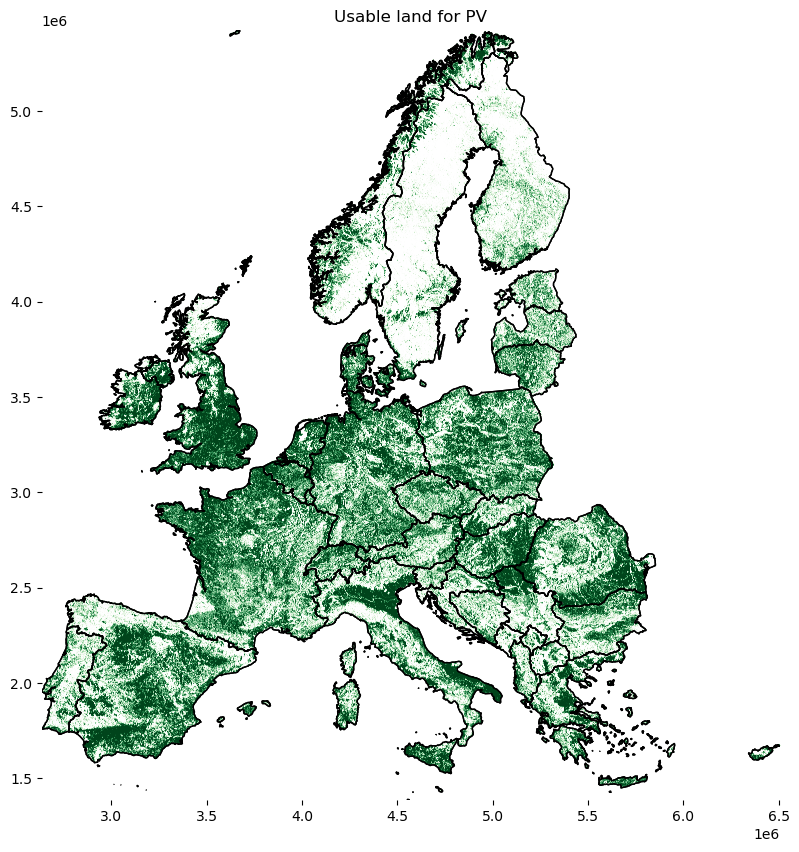

In [ ]:
# In this case, eligible share is a Dataframe with country names instead of being an array

fig, ax = plt.subplots(figsize=(10, 10))
Europe_useful.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)
count = 0
eligible_share = pd.DataFrame(np.zeros(len(europe_list)),europe_list,columns=['Ratio of available area for PV'])

for i in europe_list:
    country = Europe_useful.loc[[i]].geometry.to_crs(excluder.crs)
    masked, transform = shape_availability(country, excluder)
    eligible_share.loc[[i]] = masked.sum() * excluder.res**2 / Europe_useful.loc[[i]].geometry.item().area
    ax = show(masked, transform=transform, adjust=True, cmap="green_alpha", ax=ax);
Europe_useful.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False);
ax.set_title('Usable land for PV');

In [ ]:
# # Capacity matrix for x and y and countries
# A = Europe_era5_15.availabilitymatrix(Europe, excluder)

# # Calculating total land use matrix for PV for entire Europe: 
# A_tot = 0
# for i in europe_list:
#     A_country = A.sel(dim_0=i);
#     A_tot = A_tot + A_country;

# # Correcting elements with values > 1
# for in_x in range(154):
#     for in_y in range(186):
#         if A_tot[in_x,in_y] > 1:
#             A_tot[in_x,in_y] = 1

# # Saving corine capacity matrix to file:
# A_tot.to_netcdf(path="E://Cutouts/Corine_tot_PV.nc")

In [ ]:
# Loading corine capacity matrix from file:
A_tot = xr.open_dataarray("E://Cutouts/Corine_tot_PV.nc")

In [ ]:
# # Plotting Usable land for PV in Cutout grid
# fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(10, 10))
# A_tot.plot(ax=ax,cmap='Greens', transform=plate());

# # Europe_useful.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False);
# # cutout_grid = Europe_era5_16.grid.to_crs(excluder.crs)
# # cutout_grid.plot(ax=ax,edgecolor='grey', color='None', ls=':');
# # ax.set_title(f'Eligible area (green) {eligible_share * 100:2.2f}%');
# ax.set_title('Usable land for PV in Cutout grid');

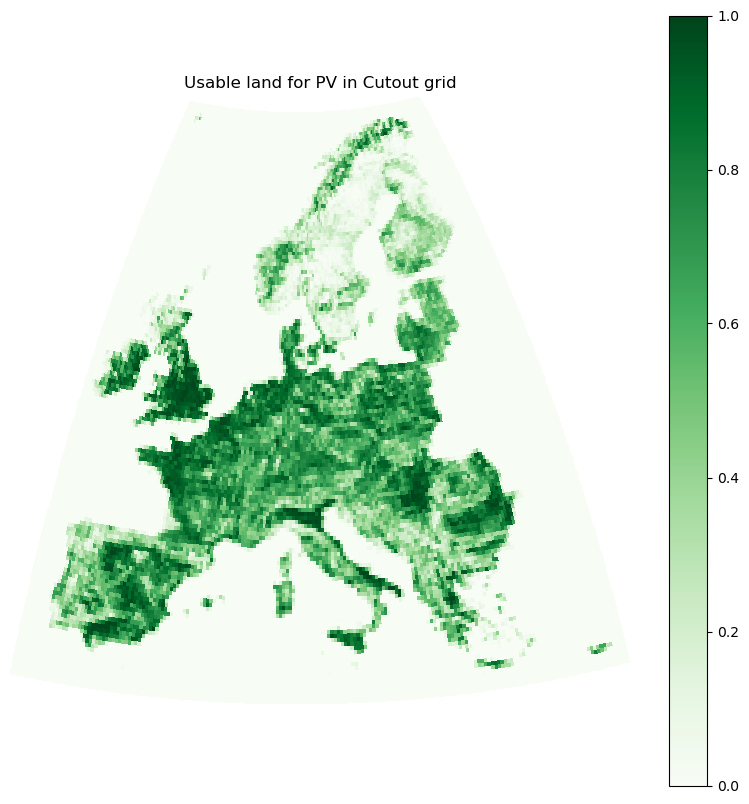

In [ ]:
# Plotting Usable land for PV in Cutout grid
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(10, 10))
A_tot.plot(ax=ax,cmap='Greens', transform=plate());
ax.spines['geo'].set_edgecolor(None)
ax.set_title('Usable land for PV in Cutout grid');

## CORINE for onshore wind production data

In [ ]:
# CORINE = "E://Cutouts/corine.tif"
excluder_wind = ExclusionContainer()

# List of excluded categories for onshore wind:
range_wind = [*range(1,11),*range(14,17),*range(22,25),29,31,*range(33,44)]

excluder_wind.add_raster(CORINE, codes=range_wind)
Europe_useful_wind = Europe.geometry.to_crs(excluder_wind.crs)

C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_8952\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Tem

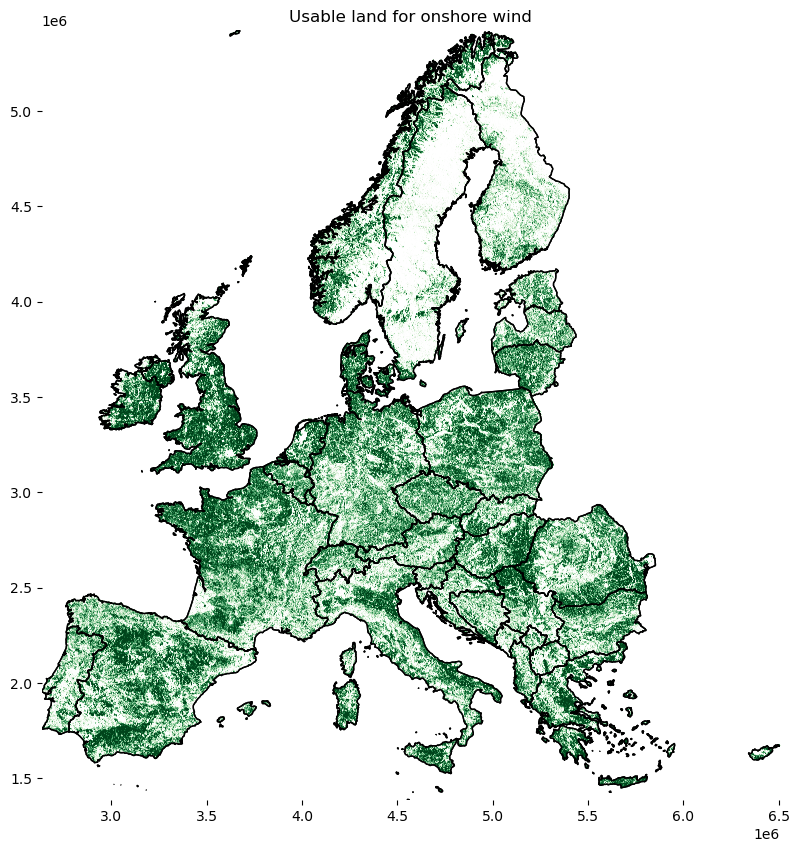

In [ ]:
# Plotting the land available for onshore wind
fig, ax = plt.subplots(figsize=(10, 10))
Europe_useful_wind.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)
count = 0
eligible_share_wind = pd.DataFrame(np.zeros(len(europe_list)),europe_list,columns=['Ratio of available area for onshore wind'])

for i in europe_list:
    country = Europe_useful_wind.loc[[i]].geometry.to_crs(excluder_wind.crs)
    masked, transform = shape_availability(country, excluder_wind)
    eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
    ax = show(masked, transform=transform, adjust=True, cmap="green_alpha", ax=ax)
    count = count + 1
Europe_useful_wind.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)
ax.set_title('Usable land for onshore wind');

In [ ]:
# # Calculating availability matrix for grid with the same size as ERA5
# A_wind = Europe_era5_16.availabilitymatrix(Europe, excluder_wind)

# # Calculating total land use matrix for entire Europe: 
# A_tot_wind = 0
# for i in europe_list:
#     A_country = A_wind.sel(dim_0=i);
#     A_tot_wind = A_tot_wind + A_country;

# # Correcting elements with values > 1
# for in_x in range(len(A_tot_wind.coords["y"])):
#     for in_y in range(len(A_tot_wind.coords["x"])):
#         if A_tot_wind[in_x,in_y] > 1:
#             A_tot_wind[in_x,in_y] = 1

# Saving corine capacity matrix to file:
# A_tot_wind.to_netcdf(path="E://Cutouts/Corine_tot_wind.nc")

In [ ]:
# Loading corine capacity matrix for wind from file:
A_tot_wind = xr.open_dataarray("E://Cutouts/Corine_tot_wind.nc")

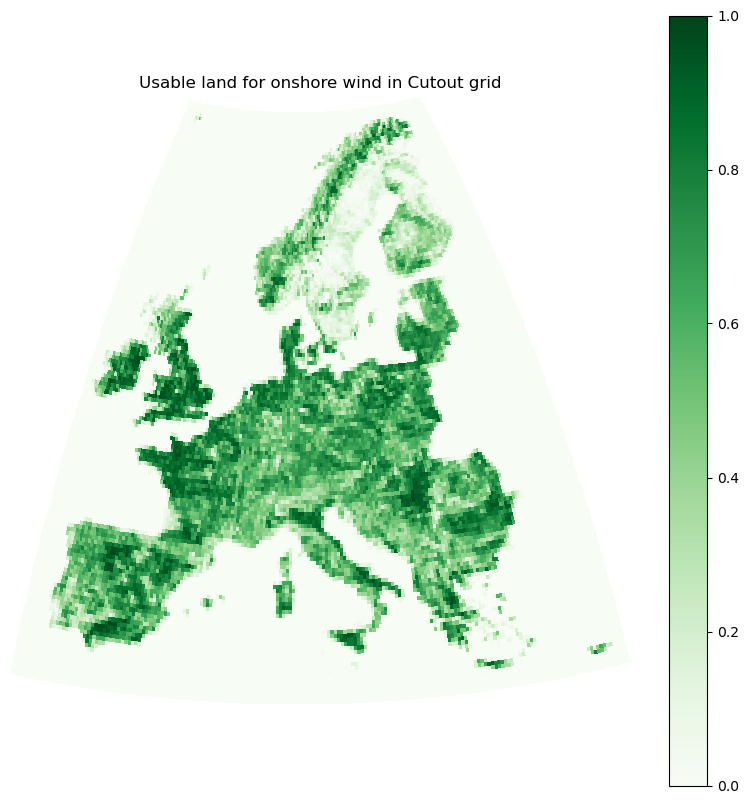

In [ ]:
# Plotting Usable land for PV in Cutout grid
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(10, 10))
A_tot_wind.plot(ax=ax,cmap='Greens', transform=plate());
ax.spines['geo'].set_edgecolor(None)
ax.set_title('Usable land for onshore wind in Cutout grid');

# Calculating final layout for onshore wind and PV

## Onshore wind - uniform layout

In [ ]:
# Create aggregated time-series for Onshore wind with proportional layout
cf_exponent=0
uniform_layout_wind=(CF_land_only_wind**cf_exponent)*A_tot_wind
total_capacity_layout=uniform_layout_wind.values.sum()

In [ ]:
# # Creating aggregated CF time series with proportional layout for wind: 
# wind_15_uniform = Europe_era5_15.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)
# wind_16_uniform = Europe_era5_16.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)
# wind_17_uniform = Europe_era5_17.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)
# wind_18_uniform = Europe_era5_18.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)
# wind_19_uniform = Europe_era5_19.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)
# wind_20_uniform = Europe_era5_20.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)
# wind_21_uniform = Europe_era5_21.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)
# wind_22_uniform = Europe_era5_22.wind(turbine=turbine, layout=uniform_layout_wind,per_unit=True)

# # Saving to files: 
# wind_15_uniform.to_netcdf(path="E:\\Cutouts\wind_15_uniform.nc")
# wind_16_uniform.to_netcdf(path="E:\\Cutouts\wind_16_uniform.nc")
# wind_17_uniform.to_netcdf(path="E:\\Cutouts\wind_17_uniform.nc")
# wind_18_uniform.to_netcdf(path="E:\\Cutouts\wind_18_uniform.nc")
# wind_19_uniform.to_netcdf(path="E:\\Cutouts\wind_19_uniform.nc")
# wind_20_uniform.to_netcdf(path="E:\\Cutouts\wind_20_uniform.nc")
# wind_21_uniform.to_netcdf(path="E:\\Cutouts\wind_21_uniform.nc")
# wind_22_uniform.to_netcdf(path="E:\\Cutouts\wind_22_uniform.nc")

In [ ]:
# Load aggregated CF for wind:
wind_15_uniform = xr.open_dataarray("E:\\Cutouts\wind_15_uniform.nc")
wind_16_uniform = xr.open_dataarray("E:\\Cutouts\wind_16_uniform.nc")
wind_17_uniform = xr.open_dataarray("E:\\Cutouts\wind_17_uniform.nc")
wind_18_uniform = xr.open_dataarray("E:\\Cutouts\wind_18_uniform.nc")
wind_19_uniform = xr.open_dataarray("E:\\Cutouts\wind_19_uniform.nc")
wind_20_uniform = xr.open_dataarray("E:\\Cutouts\wind_20_uniform.nc")
wind_21_uniform = xr.open_dataarray("E:\\Cutouts\wind_21_uniform.nc")
wind_22_uniform = xr.open_dataarray("E:\\Cutouts\wind_22_uniform.nc")

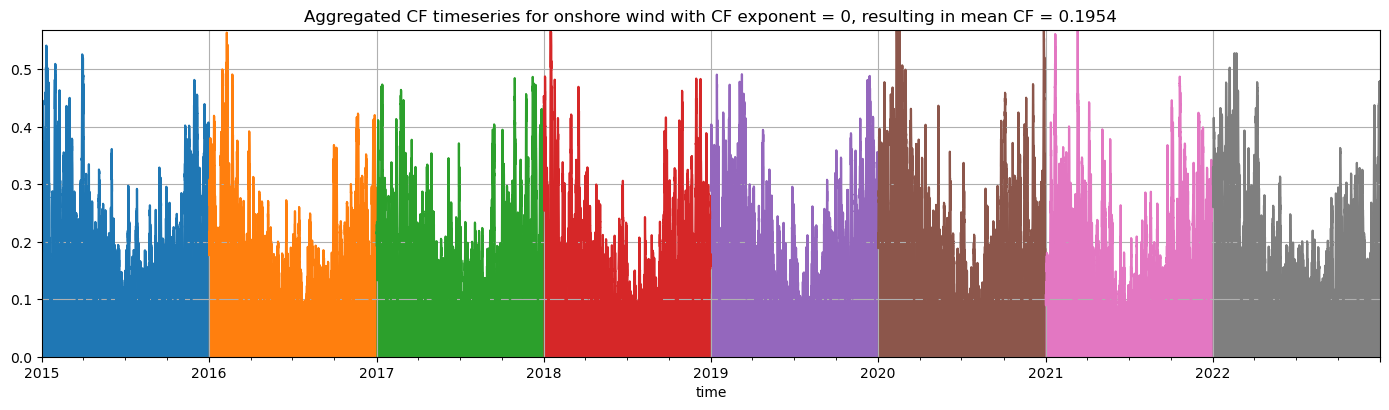

In [ ]:
# Plotting CF timeseries with average CF over 8 years
# agg_cf_wind_15 = wind_15_uniform.to_pandas()
# agg_cf_wind_16 = wind_16_uniform.to_pandas()
# agg_cf_wind_17 = wind_17_uniform.to_pandas()
# agg_cf_wind_18 = wind_18_uniform.to_pandas()
# agg_cf_wind_19 = wind_19_uniform.to_pandas()
# agg_cf_wind_20 = wind_20_uniform.to_pandas()
# agg_cf_wind_21 = wind_21_uniform.to_pandas()
# agg_cf_wind_22 = wind_22_uniform.to_pandas()

fig, ax = plt.subplots(1, figsize=(14, 4))
wind_15_uniform.to_pandas().plot.area(ax=ax, label='2018')
wind_16_uniform.to_pandas().plot.area(ax=ax, label='2018')
wind_17_uniform.to_pandas().plot.area(ax=ax, label='2018')
wind_18_uniform.to_pandas().plot.area(ax=ax, label='2018')
wind_19_uniform.to_pandas().plot.area(ax=ax, label='2019')
wind_20_uniform.to_pandas().plot.area(ax=ax, label='2020')
wind_21_uniform.to_pandas().plot.area(ax=ax, label='2020')
wind_22_uniform.to_pandas().plot.area(ax=ax, label='2020')

CF_mean_PV = (1/num_years_ERA5)*(wind_15_uniform.values.mean()
                  +wind_16_uniform.values.mean()
                  +wind_17_uniform.values.mean()
                  +wind_18_uniform.values.mean()
                  +wind_19_uniform.values.mean()
                  +wind_20_uniform.values.mean()
                  +wind_21_uniform.values.mean()
                  +wind_22_uniform.values.mean()
                  )

fig.tight_layout();
prefix = 'Aggregated CF timeseries for onshore wind with CF exponent = ';
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_PV,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
# Saving yearly average CF
CF_mean_wind_0 = [wind_15_uniform.values.mean(),
                  wind_16_uniform.values.mean(),
                  wind_17_uniform.values.mean(),
                  wind_18_uniform.values.mean(),
                  wind_19_uniform.values.mean(),
                  wind_20_uniform.values.mean(),
                  wind_21_uniform.values.mean(),
                  wind_22_uniform.values.mean(),
                  ]

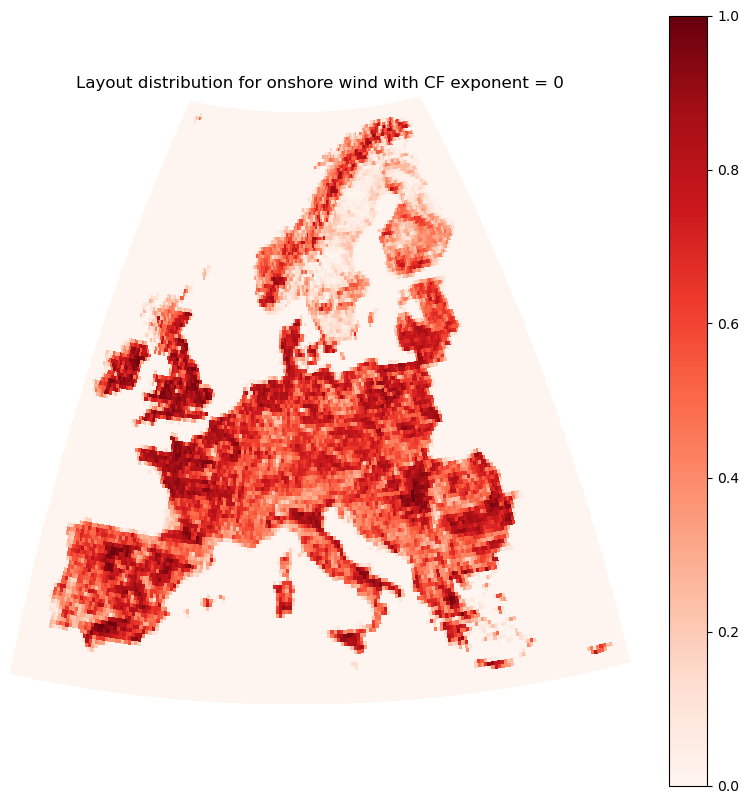

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
uniform_layout_wind.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for onshore wind with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## Onshore wind - linearly disproportional layout - CF^0.5

In [ ]:
# Create aggregated time-series for Onshore wind with proportional layout
cf_exponent=0.5
proportional_layout_wind = (CF_land_only_wind**cf_exponent)*A_tot_wind
total_capacity_layout = proportional_layout_wind.values.sum()

In [ ]:
# # Creating aggregated CF time series with proportional layout for wind:
# wind_15 = Europe_era5_15.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_16 = Europe_era5_16.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_17 = Europe_era5_17.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_18 = Europe_era5_18.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_19 = Europe_era5_19.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_20 = Europe_era5_20.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_21 = Europe_era5_21.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_22 = Europe_era5_22.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)

# # Saving to files: 
# wind_15.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_15_0.5.nc")
# wind_16.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_16_0.5.nc")
# wind_17.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_17_0.5.nc")
# wind_18.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_18_0.5.nc")
# wind_19.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_19_0.5.nc")
# wind_20.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_20_0.5.nc")
# wind_21.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_21_0.5.nc")
# wind_22.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_22_0.5.nc")

In [ ]:
# Load aggregated CF for wind:
wind_15 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_15_0.5.nc")
wind_16 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_16_0.5.nc")
wind_17 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_17_0.5.nc")
wind_18 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_18_0.5.nc")
wind_19 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_19_0.5.nc")
wind_20 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_20_0.5.nc")
wind_21 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_21_0.5.nc")
wind_22 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_22_0.5.nc")

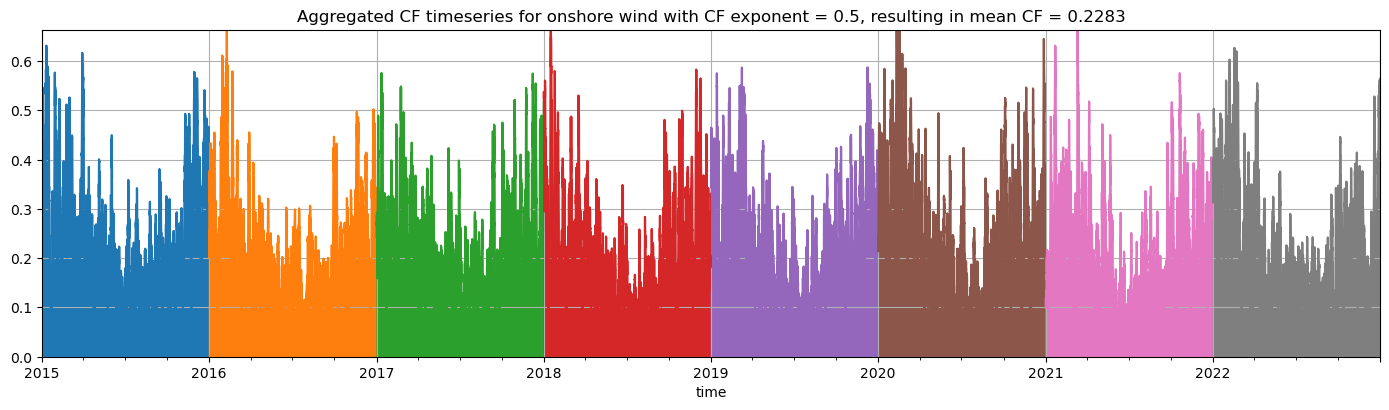

In [ ]:
# Plotting CF timeseries with average CF over 8 years
fig, ax = plt.subplots(1, figsize=(14, 4))
wind_15.to_pandas().plot.area(ax=ax, label='2015')
wind_16.to_pandas().plot.area(ax=ax, label='2016')
wind_17.to_pandas().plot.area(ax=ax, label='2017')
wind_18.to_pandas().plot.area(ax=ax, label='2018')
wind_19.to_pandas().plot.area(ax=ax, label='2019')
wind_20.to_pandas().plot.area(ax=ax, label='2020')
wind_21.to_pandas().plot.area(ax=ax, label='2021')
wind_22.to_pandas().plot.area(ax=ax, label='2022')

CF_mean_PV = (1/num_years_ERA5)*(wind_15.values.mean()
                  +wind_16.values.mean()
                  +wind_17.values.mean()
                  +wind_18.values.mean()
                  +wind_19.values.mean()
                  +wind_20.values.mean()
                  +wind_21.values.mean()
                  +wind_22.values.mean())

fig.tight_layout();
prefix = 'Aggregated CF timeseries for onshore wind with CF exponent = '; 
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_PV,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
# Saving yearly average CF
CF_mean_wind_0_5 = [wind_15.values.mean(), 
                  wind_16.values.mean(),
                  wind_17.values.mean(),
                  wind_18.values.mean(),
                  wind_19.values.mean(),
                  wind_20.values.mean(),
                  wind_21.values.mean(),
                  wind_22.values.mean(),
                    ]

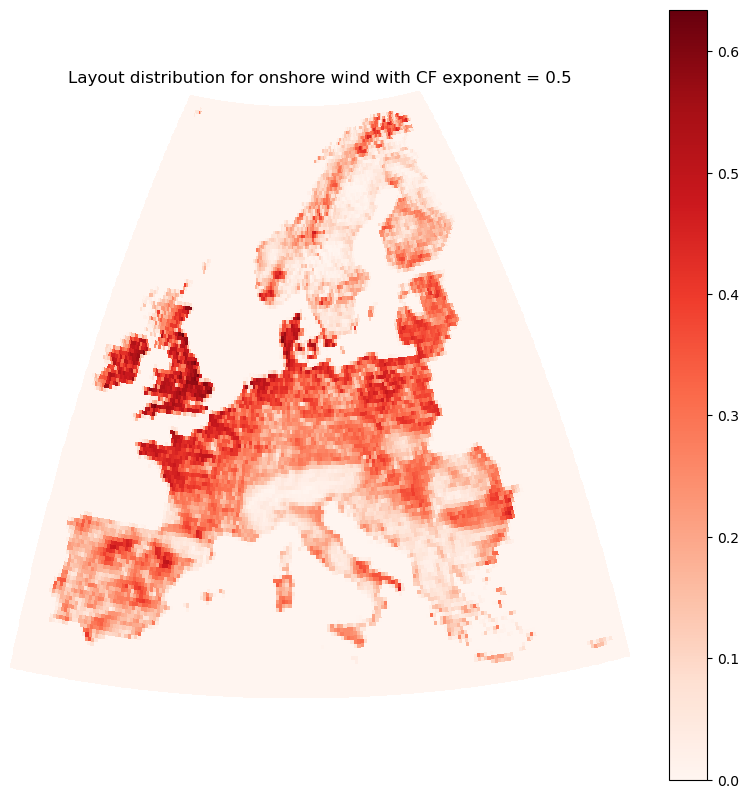

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
proportional_layout_wind.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for onshore wind with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## Onshore wind - linearly proportional layout

In [ ]:
# Create aggregated time-series for Onshore wind with proportional layout
cf_exponent=1
proportional_layout_wind=(CF_land_only_wind**cf_exponent)*A_tot_wind
total_capacity_layout=proportional_layout_wind.values.sum()

In [ ]:
# # Creating aggregated CF time series with proportional layout for wind:
# wind_15 = Europe_era5_15.wind(turbine=turbine,layout=proportional_layout_wind,per_unit=True)
# wind_16 = Europe_era5_16.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_17 = Europe_era5_17.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_18 = Europe_era5_18.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_19 = Europe_era5_19.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_20 = Europe_era5_20.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_21 = Europe_era5_21.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_22 = Europe_era5_22.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)

# # Saving to files: 
# wind_15.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_15_linear.nc")
# wind_16.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_16_linear.nc")
# wind_17.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_17_linear.nc")
# wind_18.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_18_linear.nc")
# wind_19.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_19_linear.nc")
# wind_20.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_20_linear.nc")
# wind_21.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_21_linear.nc")
# wind_22.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_22_linear.nc")

In [ ]:
# for i in range(15,23):
#     name = f'wind_{i}'
#     cutout_name = f'Europe_era5_{i}'
#     locals()[name] = locals()[cutout_name].wind(matrix=matrix_wind,turbine=turbine,layout=layout_wind,per_unit=True,index=Europe.index)

#     locals()[name].to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_15_linear.nc")


In [ ]:
# Load aggregated CF for wind:
wind_15 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_15_linear.nc")
wind_16 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_16_linear.nc")
wind_17 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_17_linear.nc")
wind_18 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_18_linear.nc")
wind_19 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_19_linear.nc")
wind_20 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_20_linear.nc")
wind_21 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_21_linear.nc")
wind_22 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_22_linear.nc")

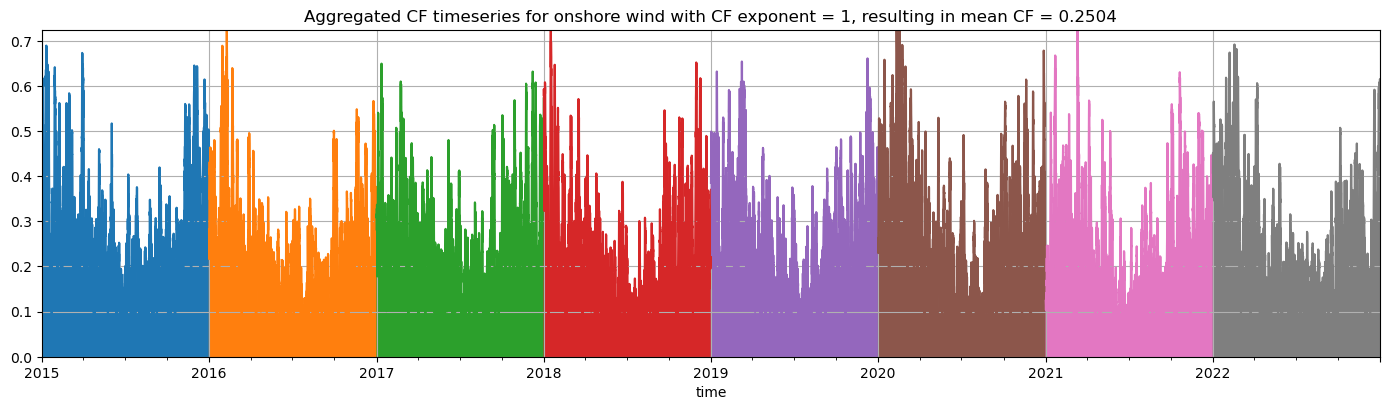

In [ ]:
# Plotting CF timeseries with average CF over 8 years
fig, ax = plt.subplots(1, figsize=(14, 4))
wind_15.to_pandas().plot.area(ax=ax, label='2015')
wind_16.to_pandas().plot.area(ax=ax, label='2016')
wind_17.to_pandas().plot.area(ax=ax, label='2017')
wind_18.to_pandas().plot.area(ax=ax, label='2018')
wind_19.to_pandas().plot.area(ax=ax, label='2019')
wind_20.to_pandas().plot.area(ax=ax, label='2020')
wind_21.to_pandas().plot.area(ax=ax, label='2021')
wind_22.to_pandas().plot.area(ax=ax, label='2022')

CF_mean_PV = (1/num_years_ERA5)*(wind_15.values.mean()
                  +wind_16.values.mean()
                  +wind_17.values.mean()
                  +wind_18.values.mean()
                  +wind_19.values.mean()
                  +wind_20.values.mean()
                  +wind_21.values.mean()
                  +wind_22.values.mean())

fig.tight_layout();
prefix = 'Aggregated CF timeseries for onshore wind with CF exponent = '; 
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_PV,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
# Saving yearly average CF
CF_mean_wind_1 = [wind_15.values.mean(), 
                  wind_16.values.mean(),
                  wind_17.values.mean(),
                  wind_18.values.mean(),
                  wind_19.values.mean(),
                  wind_20.values.mean(),
                  wind_21.values.mean(),
                  wind_22.values.mean(),
                    ]

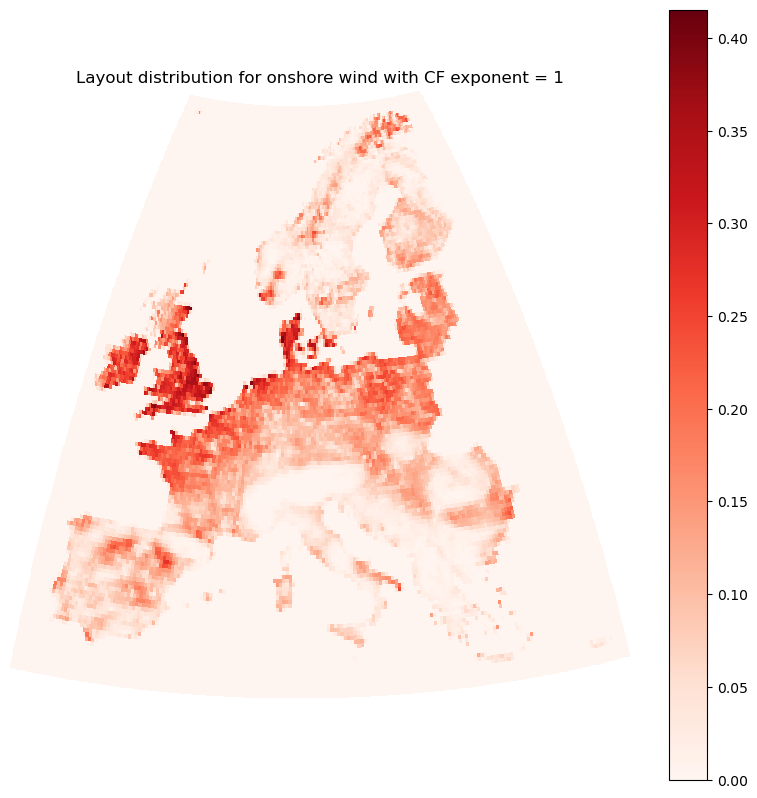

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
proportional_layout_wind.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for onshore wind with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## Onshore wind - proportional layout

In [ ]:
# Create aggregated time-series for Onshore wind with proportional layout
cf_exponent=1.5
proportional_layout_wind=(CF_land_only_wind**cf_exponent)*A_tot_wind
total_capacity_layout=proportional_layout_wind.values.sum()

In [ ]:
# # Creating aggregated CF time series with proportional layout for wind:
# wind_15 = Europe_era5_15.wind(turbine=turbine,layout=proportional_layout_wind,per_unit=True)
# wind_16 = Europe_era5_16.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_17 = Europe_era5_17.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_18 = Europe_era5_18.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_19 = Europe_era5_19.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_20 = Europe_era5_20.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_21 = Europe_era5_21.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_22 = Europe_era5_22.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)

# # Saving to files: 
# wind_15.to_netcdf(path="E:\\Cutouts\wind_15.nc")
# wind_16.to_netcdf(path="E:\\Cutouts\wind_16.nc")
# wind_17.to_netcdf(path="E:\\Cutouts\wind_17.nc")
# wind_18.to_netcdf(path="E:\\Cutouts\wind_18.nc")
# wind_19.to_netcdf(path="E:\\Cutouts\wind_19.nc")
# wind_20.to_netcdf(path="E:\\Cutouts\wind_20.nc")
# wind_21.to_netcdf(path="E:\\Cutouts\wind_21.nc")
# wind_22.to_netcdf(path="E:\\Cutouts\wind_22.nc")

In [ ]:
# Load aggregated CF for wind:
wind_15 = xr.open_dataarray("E:\\Cutouts\wind_15.nc")
wind_16 = xr.open_dataarray("E:\\Cutouts\wind_16.nc")
wind_17 = xr.open_dataarray("E:\\Cutouts\wind_17.nc")
wind_18 = xr.open_dataarray("E:\\Cutouts\wind_18.nc")
wind_19 = xr.open_dataarray("E:\\Cutouts\wind_19.nc")
wind_20 = xr.open_dataarray("E:\\Cutouts\wind_20.nc")
wind_21 = xr.open_dataarray("E:\\Cutouts\wind_21.nc")
wind_22 = xr.open_dataarray("E:\\Cutouts\wind_22.nc")

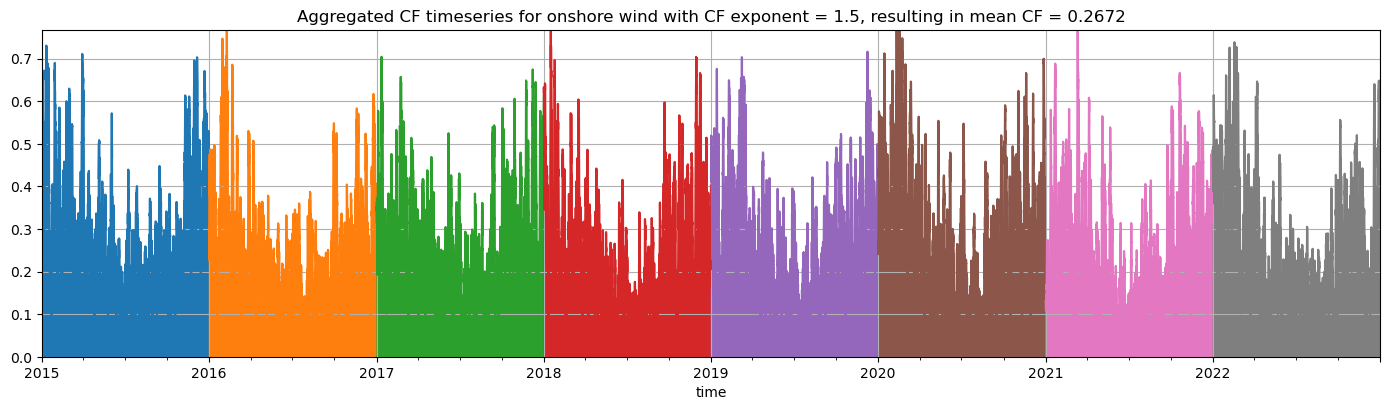

In [ ]:
# Plotting CF timeseries with average CF over 8 years
# agg_cf_wind_15 = wind_15.to_pandas()
# agg_cf_wind_16 = wind_16.to_pandas()
# agg_cf_wind_17 = wind_17.to_pandas()
# agg_cf_wind_18 = wind_18.to_pandas()
# agg_cf_wind_19 = wind_19.to_pandas()
# agg_cf_wind_20 = wind_20.to_pandas()
# agg_cf_wind_21 = wind_21.to_pandas()
# agg_cf_wind_22 = wind_22.to_pandas()

fig, ax = plt.subplots(1, figsize=(14, 4))
wind_15.to_pandas().plot.area(ax=ax, label='2015')
wind_16.to_pandas().plot.area(ax=ax, label='2016')
wind_17.to_pandas().plot.area(ax=ax, label='2017')
wind_18.to_pandas().plot.area(ax=ax, label='2018')
wind_19.to_pandas().plot.area(ax=ax, label='2019')
wind_20.to_pandas().plot.area(ax=ax, label='2020')
wind_21.to_pandas().plot.area(ax=ax, label='2021')
wind_22.to_pandas().plot.area(ax=ax, label='2022')

CF_mean_PV = (1/num_years_ERA5)*(wind_15.values.mean()
                  +wind_16.values.mean()
                  +wind_17.values.mean()
                  +wind_18.values.mean()
                  +wind_19.values.mean()
                  +wind_20.values.mean()
                  +wind_21.values.mean()
                  +wind_22.values.mean())

fig.tight_layout();
prefix = 'Aggregated CF timeseries for onshore wind with CF exponent = '; 
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_PV,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
# Saving yearly average CF
CF_mean_wind_1_5 = [wind_15.values.mean(), 
                  wind_16.values.mean(),
                  wind_17.values.mean(),
                  wind_18.values.mean(),
                  wind_19.values.mean(),
                  wind_20.values.mean(),
                  wind_21.values.mean(),
                  wind_22.values.mean(),
                    ]

In [ ]:
# agg_cf_wind = Europe_era5_15.wind(turbine=turbine,layout=proportional_layout_wind,per_unit=True).to_pandas()
# fig, ax = plt.subplots(1, figsize=(14, 4))
# agg_cf_wind.plot.area(ax=ax)
# CF_mean = agg_cf_wind.values.mean();

# fig.tight_layout();
# prefix = 'Aggregated CF timeseries for onshore wind with CF exponent = ';
# suffix = ', resulting in mean CF = '
# plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean,4)}');
# ax.get_legend().remove()
# plt.grid()

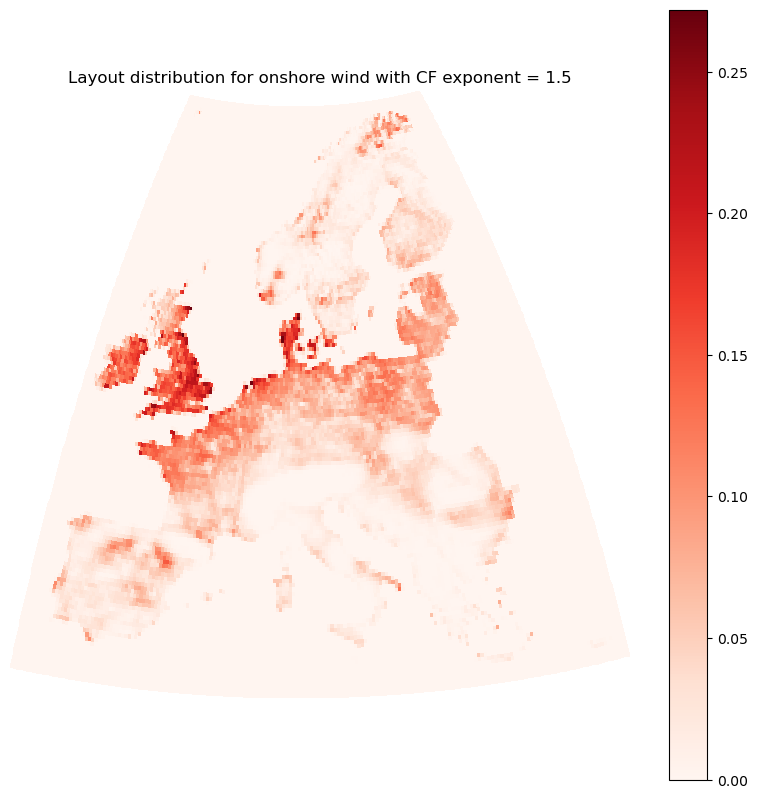

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
proportional_layout_wind.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for onshore wind with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## Onshore wind - linearly disproportional layout - CF^2.0

In [ ]:
# Create aggregated time-series for Onshore wind with proportional layout
cf_exponent=2
proportional_layout_wind = (CF_land_only_wind**cf_exponent)*A_tot_wind
total_capacity_layout = proportional_layout_wind.values.sum()

In [ ]:
# # Creating aggregated CF time series with proportional layout for wind:
# wind_15 = Europe_era5_15.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_16 = Europe_era5_16.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_17 = Europe_era5_17.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_18 = Europe_era5_18.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_19 = Europe_era5_19.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_20 = Europe_era5_20.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_21 = Europe_era5_21.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)
# wind_22 = Europe_era5_22.wind(turbine=turbine, layout=proportional_layout_wind,per_unit=True)

# # Saving to files: 
# wind_15.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_15_2.0.nc")
# wind_16.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_16_2.0.nc")
# wind_17.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_17_2.0.nc")
# wind_18.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_18_2.0.nc")
# wind_19.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_19_2.0.nc")
# wind_20.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_20_2.0.nc")
# wind_21.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_21_2.0.nc")
# wind_22.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\wind_22_2.0.nc")

In [ ]:
# Load aggregated CF for wind:
wind_15 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_15_2.0.nc")
wind_16 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_16_2.0.nc")
wind_17 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_17_2.0.nc")
wind_18 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_18_2.0.nc")
wind_19 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_19_2.0.nc")
wind_20 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_20_2.0.nc")
wind_21 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_21_2.0.nc")
wind_22 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\wind_22_2.0.nc")

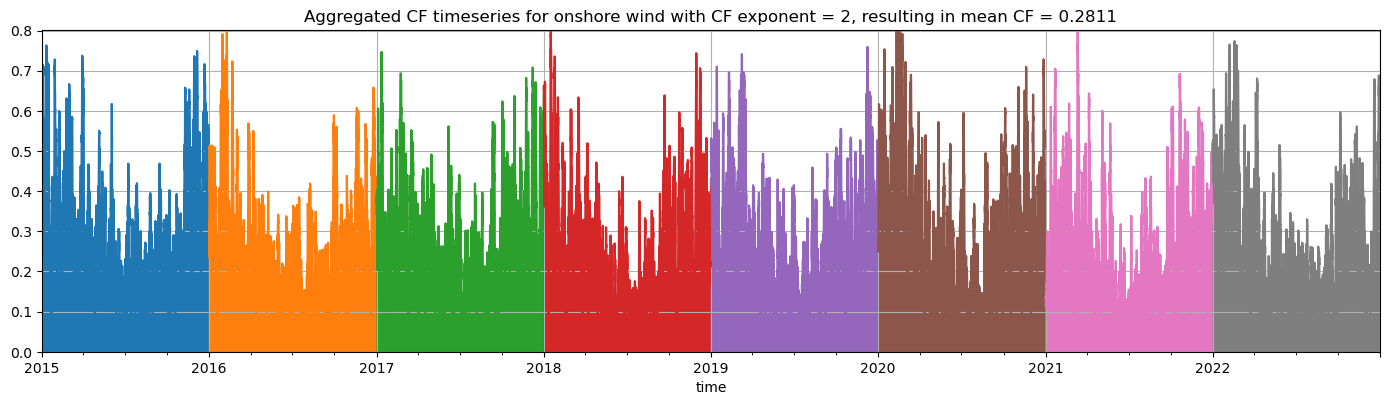

In [ ]:
# Plotting CF timeseries with average CF over 8 years
fig, ax = plt.subplots(1, figsize=(14, 4))
wind_15.to_pandas().plot.area(ax=ax, label='2015')
wind_16.to_pandas().plot.area(ax=ax, label='2016')
wind_17.to_pandas().plot.area(ax=ax, label='2017')
wind_18.to_pandas().plot.area(ax=ax, label='2018')
wind_19.to_pandas().plot.area(ax=ax, label='2019')
wind_20.to_pandas().plot.area(ax=ax, label='2020')
wind_21.to_pandas().plot.area(ax=ax, label='2021')
wind_22.to_pandas().plot.area(ax=ax, label='2022')

CF_mean_wind = (1/num_years_ERA5)*(wind_15.values.mean()
                  +wind_16.values.mean()
                  +wind_17.values.mean()
                  +wind_18.values.mean()
                  +wind_19.values.mean()
                  +wind_20.values.mean()
                  +wind_21.values.mean()
                  +wind_22.values.mean())

fig.tight_layout();
prefix = 'Aggregated CF timeseries for onshore wind with CF exponent = '; 
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_wind,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
CF_mean_wind_2 = [wind_15.values.mean(), 
                  wind_16.values.mean(),
                  wind_17.values.mean(),
                  wind_18.values.mean(),
                  wind_19.values.mean(),
                  wind_20.values.mean(),
                  wind_21.values.mean(),
                  wind_22.values.mean(),
                    ]

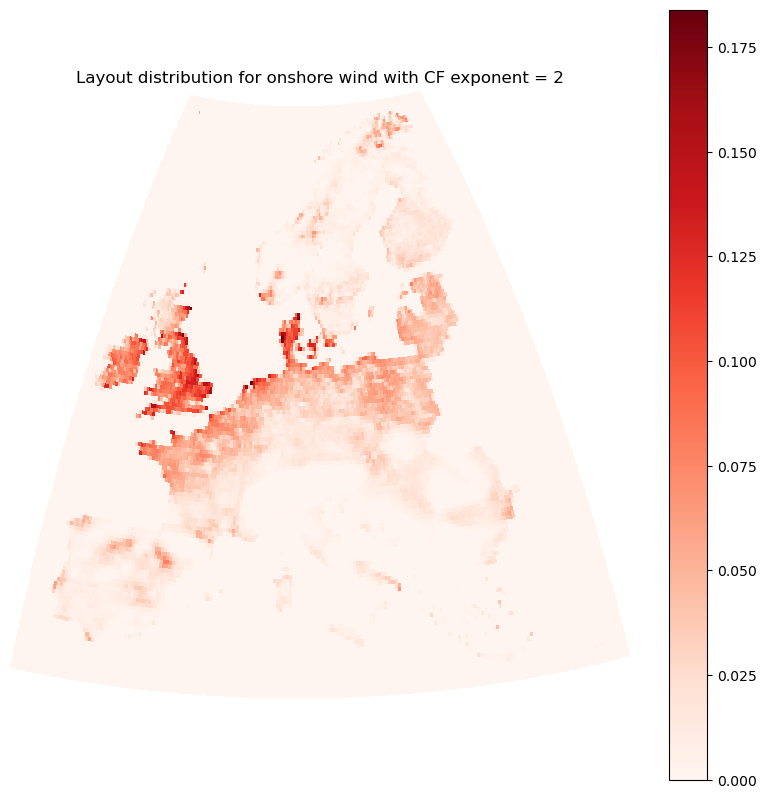

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
proportional_layout_wind.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for onshore wind with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## Creating layout distribution comparison with annual variability

In [ ]:
# fig, ax = plt.subplots(figsize=(8,4));
# ax.plot(CF_mean_wind.index, averaged_CF.iloc[0], marker='.', markersize=15, linestyle='-', color='k');
# plt.fill_between(CF_mean_wind.index, averaged_CF.iloc[0]-errors[0], averaged_CF.iloc[0]+errors[1]);
# ax.set_title('Effect of layout based on exponential capacity factor on average Capacity factor');

## PV - uniform layout

In [ ]:
# Create aggregated time-series for PV with uniform layout
cf_exponent=0
uniform_layout_PV=(CF_land_only_PV**cf_exponent)*A_tot
total_capacity_layout=uniform_layout_PV.values.sum()

In [ ]:
# # Creating aggregated CF time series with uniform layout for PV
# PV_15_uniform = Europe_era5_15.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)
# PV_16_uniform = Europe_era5_16.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)
# PV_17_uniform = Europe_era5_17.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)
# PV_18_uniform = Europe_era5_18.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)
# PV_19_uniform = Europe_era5_19.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)
# PV_20_uniform = Europe_era5_20.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)
# PV_21_uniform = Europe_era5_21.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)
# PV_22_uniform = Europe_era5_22.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal",layout=uniform_layout_PV,per_unit=True)

# # Saving to files: 
# PV_15_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_15_uniform.nc")
# PV_16_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_16_uniform.nc")
# PV_17_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_17_uniform.nc")
# PV_18_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_18_uniform.nc")
# PV_19_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_19_uniform.nc")
# PV_20_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_20_uniform.nc")
# PV_21_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_21_uniform.nc")
# PV_22_uniform.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_22_uniform.nc")

In [ ]:
# Load aggregated CF for PV
PV_15_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_15_uniform.nc")
PV_16_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_16_uniform.nc")
PV_17_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_17_uniform.nc")
PV_18_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_18_uniform.nc")
PV_19_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_19_uniform.nc")
PV_20_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_20_uniform.nc")
PV_21_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_21_uniform.nc")
PV_22_uniform = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_22_uniform.nc")

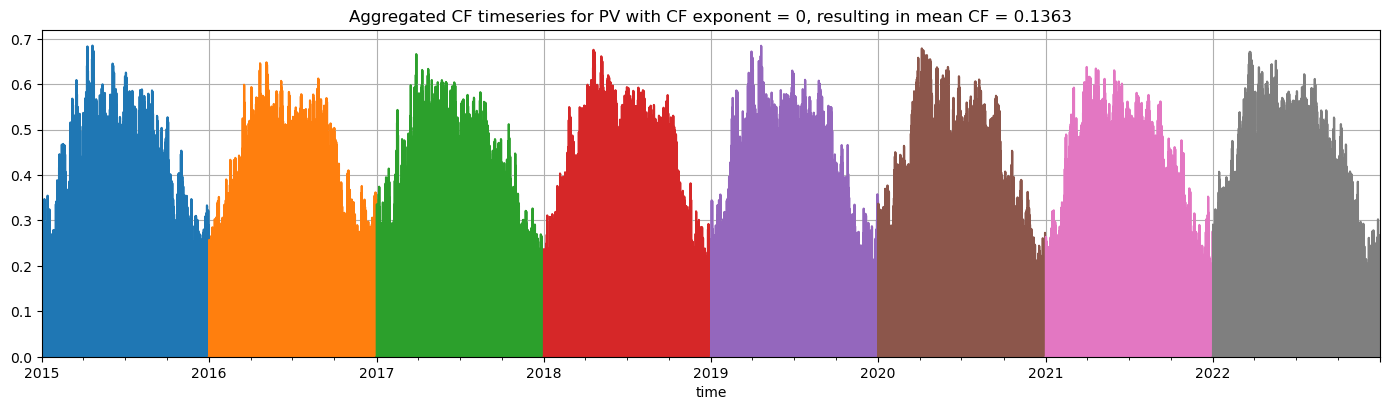

In [ ]:
# Plotting CF timeseries with average CF over 8 years
agg_cf_PV_15 = PV_15_uniform.to_pandas()
agg_cf_PV_16 = PV_16_uniform.to_pandas()
agg_cf_PV_17 = PV_17_uniform.to_pandas()
agg_cf_PV_18 = PV_18_uniform.to_pandas()
agg_cf_PV_19 = PV_19_uniform.to_pandas()
agg_cf_PV_20 = PV_20_uniform.to_pandas()
agg_cf_PV_21 = PV_21_uniform.to_pandas()
agg_cf_PV_22 = PV_22_uniform.to_pandas()

fig, ax = plt.subplots(1, figsize=(14, 4))
agg_cf_PV_15.plot.area(ax=ax, label='2015')
agg_cf_PV_16.plot.area(ax=ax, label='2016')
agg_cf_PV_17.plot.area(ax=ax, label='2017')
agg_cf_PV_18.plot.area(ax=ax, label='2018')
agg_cf_PV_19.plot.area(ax=ax, label='2019')
agg_cf_PV_20.plot.area(ax=ax, label='2020')
agg_cf_PV_21.plot.area(ax=ax, label='2021')
agg_cf_PV_22.plot.area(ax=ax, label='2022')

CF_mean_PV = (1/num_years_ERA5)*(agg_cf_PV_15.values.mean()
                  +agg_cf_PV_16.values.mean()
                  +agg_cf_PV_17.values.mean()
                  +agg_cf_PV_18.values.mean()
                  +agg_cf_PV_19.values.mean()
                  +agg_cf_PV_20.values.mean()
                  +agg_cf_PV_21.values.mean()
                  +agg_cf_PV_22.values.mean())

fig.tight_layout();
prefix = 'Aggregated CF timeseries for PV with CF exponent = ';
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_PV,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
CF_mean_PV_0 = [agg_cf_PV_15.values.mean(),
                  agg_cf_PV_16.values.mean(),
                  agg_cf_PV_17.values.mean(),
                  agg_cf_PV_18.values.mean(),
                  agg_cf_PV_19.values.mean(),
                  agg_cf_PV_20.values.mean(),
                  agg_cf_PV_21.values.mean(),
                  agg_cf_PV_22.values.mean(), 
                  ]

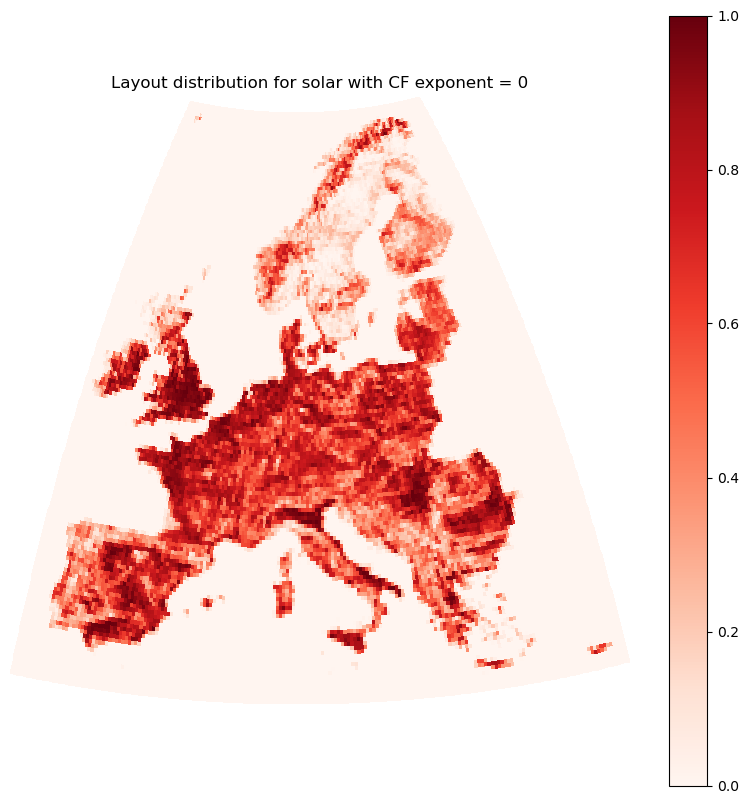

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
uniform_layout_PV.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for solar with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## PV - proportional layout

In [ ]:
# Create aggregated time-series for PV with proportional layout
cf_exponent=1
proportional_layout_PV=(CF_land_only_PV**cf_exponent)*A_tot
total_capacity_layout=proportional_layout_PV.values.sum()

In [ ]:
# # Creating aggregated CF time series with proportional layout for PV
# PV_15 = Europe_era5_15.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_16 = Europe_era5_16.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_17 = Europe_era5_17.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_18 = Europe_era5_18.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_19 = Europe_era5_19.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_20 = Europe_era5_20.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_21 = Europe_era5_21.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_22 = Europe_era5_22.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)

# # Saving to files: 
# PV_15.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_15.nc")
# PV_16.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_16.nc")
# PV_17.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_17.nc")
# PV_18.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_18.nc")
# PV_19.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_19.nc")
# PV_20.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_20.nc")
# PV_21.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_21.nc")
# PV_22.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_22.nc")

In [ ]:
# Load aggregated CF for PV
PV_15 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_15.nc")
PV_16 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_16.nc")
PV_17 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_17.nc")
PV_18 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_18.nc")
PV_19 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_19.nc")
PV_20 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_20.nc")
PV_21 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_21.nc")
PV_22 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_22.nc")

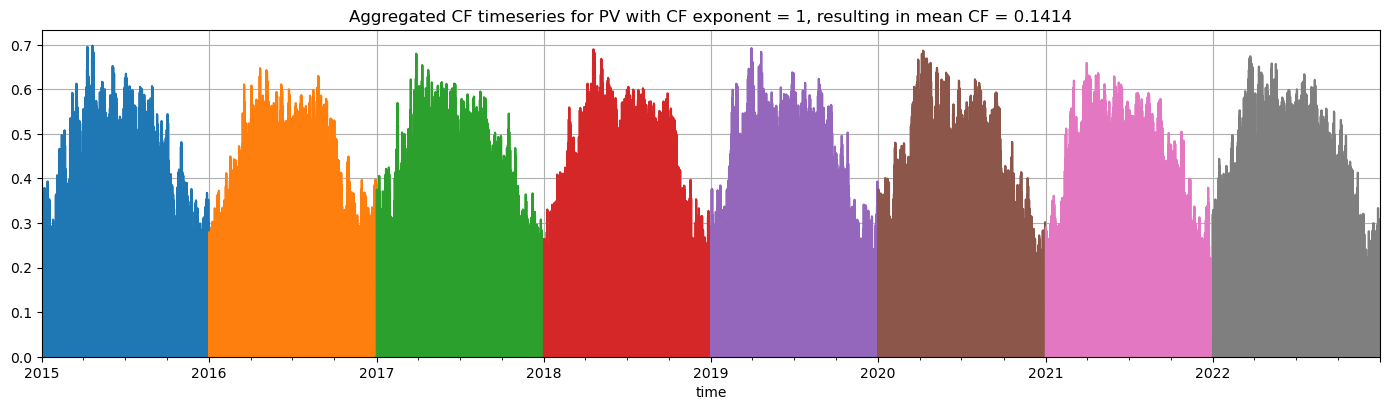

In [ ]:
# Plotting CF timeseries with average CF over 8 years

fig, ax = plt.subplots(1, figsize=(14, 4))
PV_15.to_pandas().plot.area(ax=ax)
PV_16.to_pandas().plot.area(ax=ax)
PV_17.to_pandas().plot.area(ax=ax)
PV_18.to_pandas().plot.area(ax=ax)
PV_19.to_pandas().plot.area(ax=ax)
PV_20.to_pandas().plot.area(ax=ax)
PV_21.to_pandas().plot.area(ax=ax)
PV_22.to_pandas().plot.area(ax=ax)

CF_mean_PV = (1/num_years_ERA5)*(PV_15.values.mean()
                  +PV_16.values.mean()
                  +PV_17.values.mean()
                  +PV_18.values.mean()
                  +PV_19.values.mean()
                  +PV_20.values.mean()
                  +PV_21.values.mean()
                  +PV_22.values.mean())

fig.tight_layout();
prefix = 'Aggregated CF timeseries for PV with CF exponent = ';
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_PV,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
CF_mean_PV_1 = [
                PV_15.values.mean(),
                PV_16.values.mean(),
                PV_17.values.mean(),
                PV_18.values.mean(),
                PV_19.values.mean(),
                PV_20.values.mean(),
                PV_21.values.mean(),
                PV_22.values.mean(),
                ]

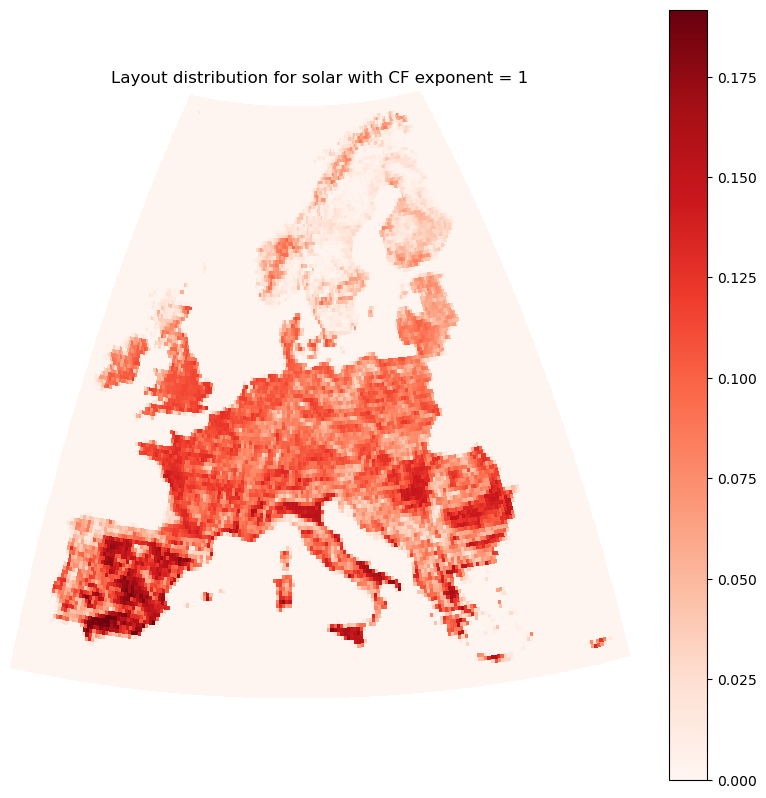

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
proportional_layout_PV.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for solar with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## PV - proportional layout with CF exponent = 2

In [ ]:
# Create aggregated time-series for PV with proportional layout
cf_exponent=2
proportional_layout_PV=(CF_land_only_PV**cf_exponent)*A_tot
total_capacity_layout=proportional_layout_PV.values.sum()

In [ ]:
# # Creating aggregated CF time series with proportional layout for PV
# PV_15 = Europe_era5_15.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_16 = Europe_era5_16.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_17 = Europe_era5_17.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_18 = Europe_era5_18.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_19 = Europe_era5_19.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_20 = Europe_era5_20.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_21 = Europe_era5_21.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)
# PV_22 = Europe_era5_22.pv(panel=atlite.solarpanels.CSi,orientation="latitude_optimal", layout=proportional_layout_PV,per_unit=True)

# # Saving to files: 
# PV_15.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_15_2.0.nc")
# PV_16.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_16_2.0.nc")
# PV_17.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_17_2.0.nc")
# PV_18.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_18_2.0.nc")
# PV_19.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_19_2.0.nc")
# PV_20.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_20_2.0.nc")
# PV_21.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_21_2.0.nc")
# PV_22.to_netcdf(path="E:\\Cutouts\Aggregated CF timeseries\PV_22_2.0.nc")

In [ ]:
# Load aggregated CF for PV
PV_15 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_15_2.0.nc")
PV_16 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_16_2.0.nc")
PV_17 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_17_2.0.nc")
PV_18 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_18_2.0.nc")
PV_19 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_19_2.0.nc")
PV_20 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_20_2.0.nc")
PV_21 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_21_2.0.nc")
PV_22 = xr.open_dataarray("E:\\Cutouts\Aggregated CF timeseries\PV_22_2.0.nc")

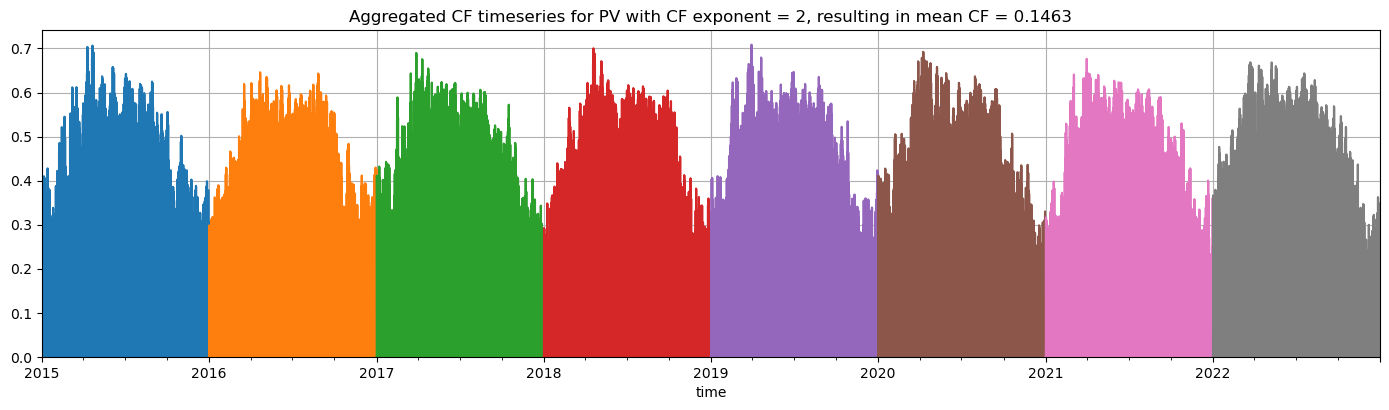

In [ ]:
# Plotting CF timeseries with average CF over 8 years

fig, ax = plt.subplots(1, figsize=(14, 4))
PV_15.to_pandas().plot.area(ax=ax)
PV_16.to_pandas().plot.area(ax=ax)
PV_17.to_pandas().plot.area(ax=ax)
PV_18.to_pandas().plot.area(ax=ax)
PV_19.to_pandas().plot.area(ax=ax)
PV_20.to_pandas().plot.area(ax=ax)
PV_21.to_pandas().plot.area(ax=ax)
PV_22.to_pandas().plot.area(ax=ax)

CF_mean_PV = (1/num_years_ERA5)*(PV_15.values.mean()
                  +PV_16.values.mean()
                  +PV_17.values.mean()
                  +PV_18.values.mean()
                  +PV_19.values.mean()
                  +PV_20.values.mean()
                  +PV_21.values.mean()
                  +PV_22.values.mean())

fig.tight_layout();
prefix = 'Aggregated CF timeseries for PV with CF exponent = ';
suffix = ', resulting in mean CF = '
plt.title(f'{prefix}{cf_exponent}{suffix}{round(CF_mean_PV,4)}');
ax.get_legend().remove()
plt.grid()

In [ ]:
CF_mean_PV_2 = [
                PV_15.values.mean(),
                PV_16.values.mean(),
                PV_17.values.mean(),
                PV_18.values.mean(),
                PV_19.values.mean(),
                PV_20.values.mean(),
                PV_21.values.mean(),
                PV_22.values.mean(),
                ]

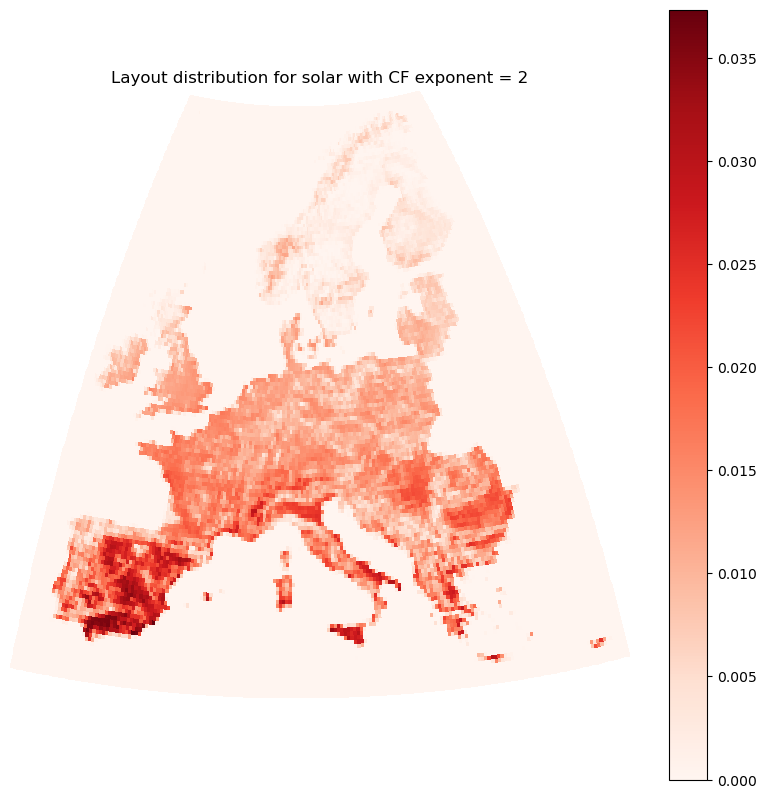

In [ ]:
# Plotting layout for onshore wind
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=map_fig_size);
proportional_layout_PV.plot(cmap="Reds",transform=plate(), ax=ax);
# Removing frame: 
ax.spines['geo'].set_edgecolor('None')
prefix = 'Layout distribution for solar with CF exponent = ';
plt.title(f'{prefix}{cf_exponent}');

## Creating layout distribution comparison with annual variability

In [ ]:
# Starting with Onshore wind: 

CF_exponents = [0, 0.5, 1, 1.5, 2]
CF_mean_wind = pd.DataFrame()
CF_mean_wind['CF exponents'] = CF_exponents
CF_mean_wind.set_index('CF exponents', inplace=True)

In [ ]:
for i in range(num_years_ERA5): 
    CF_mean_wind[2015+i] = [CF_mean_wind_0[i], 
                            CF_mean_wind_0_5[i], 
                            CF_mean_wind_1[i], 
                            CF_mean_wind_1_5[i], 
                            CF_mean_wind_2[i], 
                            ]
CF_mean_wind

2015      2016      2017      2018      2019      2020  \
CF exponents                                                               
0.0           0.207854  0.182427  0.198160  0.185051  0.200862  0.211919   
0.5           0.244475  0.212464  0.231353  0.215962  0.233836  0.248542   
1.0           0.269601  0.232662  0.253714  0.236746  0.255676  0.273391   
1.5           0.288992  0.248124  0.270811  0.252645  0.272059  0.292363   
2.0           0.305096  0.260974  0.284978  0.265858  0.285382  0.307955   

                  2021      2022  
CF exponents                      
0.0           0.185968  0.191270  
0.5           0.216052  0.223543  
1.0           0.235854  0.245279  
1.5           0.250644  0.261882  
2.0           0.262628  0.275629

In [ ]:
averaged_CF = pd.DataFrame()
for i in range(len(CF_mean_wind.index)):
    averaged_CF[CF_exponents[i]] = [CF_mean_wind.iloc[i].mean()]
averaged_CF

0.0       0.5       1.0      1.5       2.0
0  0.195439  0.228278  0.250365  0.26719  0.281063

In [ ]:
errors = [(CF_mean_wind.iloc[0].min(), 
           CF_mean_wind.iloc[1].min(),
           CF_mean_wind.iloc[2].min(),
           CF_mean_wind.iloc[3].min(),
           CF_mean_wind.iloc[4].min(),
           ), 
           (CF_mean_wind.iloc[0].max(),
            CF_mean_wind.iloc[1].max(),
            CF_mean_wind.iloc[2].max(),
            CF_mean_wind.iloc[3].max(),
            CF_mean_wind.iloc[4].max(), 
            )]
errors

[(0.18242739580687567,
  0.21246381261249878,
  0.2326621803305735,
  0.24812433084680727,
  0.26097351539938957),
 (0.21191940855179667,
  0.2485422435322301,
  0.27339098518795507,
  0.29236262376887395,
  0.30795492941211206)]

In [ ]:
errors[0] = abs(errors[0]-averaged_CF.iloc[0].values)
errors[1] = abs(errors[1]-averaged_CF.iloc[0].values)
errors

[array([0.01301146, 0.01581453, 0.01770326, 0.01906564, 0.02008902]),
 array([0.01648055, 0.0202639 , 0.02302554, 0.02517265, 0.0268924 ])]

In [ ]:
# Same procedure for solar: 

CF_mean_PV = pd.DataFrame()
CF_exponents_PV = [0, 1, 2]
CF_mean_PV['CF exponents'] = CF_exponents_PV
CF_mean_PV.set_index('CF exponents', inplace=True)

In [ ]:
for i in range(num_years_ERA5): 
    CF_mean_PV[2015+i] = [CF_mean_PV_0[i], 
                          CF_mean_PV_1[i], 
                          CF_mean_PV_2[i], 
                        ]
CF_mean_PV

2015      2016      2017      2018      2019      2020  \
CF exponents                                                               
0             0.135749  0.132849  0.135123  0.137306  0.137826  0.136797   
1             0.141012  0.137830  0.140951  0.141603  0.143038  0.141593   
2             0.146109  0.142709  0.146712  0.145694  0.148083  0.146227   

                  2021      2022  
CF exponents                      
0             0.135286  0.139439  
1             0.140349  0.144472  
2             0.145277  0.149235

In [ ]:
averaged_CF_PV = pd.DataFrame()
for i in range(len(CF_mean_PV.index)):
    averaged_CF_PV[CF_exponents_PV[i]] = [CF_mean_PV.iloc[i].mean()]
averaged_CF_PV

0         1         2
0  0.136297  0.141356  0.146256

In [ ]:
errors_PV = [(CF_mean_PV.iloc[0].min(), 
           CF_mean_PV.iloc[1].min(),
           CF_mean_PV.iloc[2].min(),
           ), 
           (CF_mean_PV.iloc[0].max(),
            CF_mean_PV.iloc[1].max(),
            CF_mean_PV.iloc[2].max(),
            )]
errors_PV

[(0.1328486860227068, 0.1378299043533595, 0.1427085984618877),
 (0.1394390968022768, 0.14447221303553237, 0.14923521381748342)]

In [ ]:
errors_PV[0] = abs(errors_PV[0]-averaged_CF_PV.iloc[0].values)
errors_PV[1] = abs(errors_PV[1]-averaged_CF_PV.iloc[0].values)
errors_PV

[array([0.00344835, 0.00352612, 0.00354715]),
 array([0.00314206, 0.00311619, 0.00297947])]

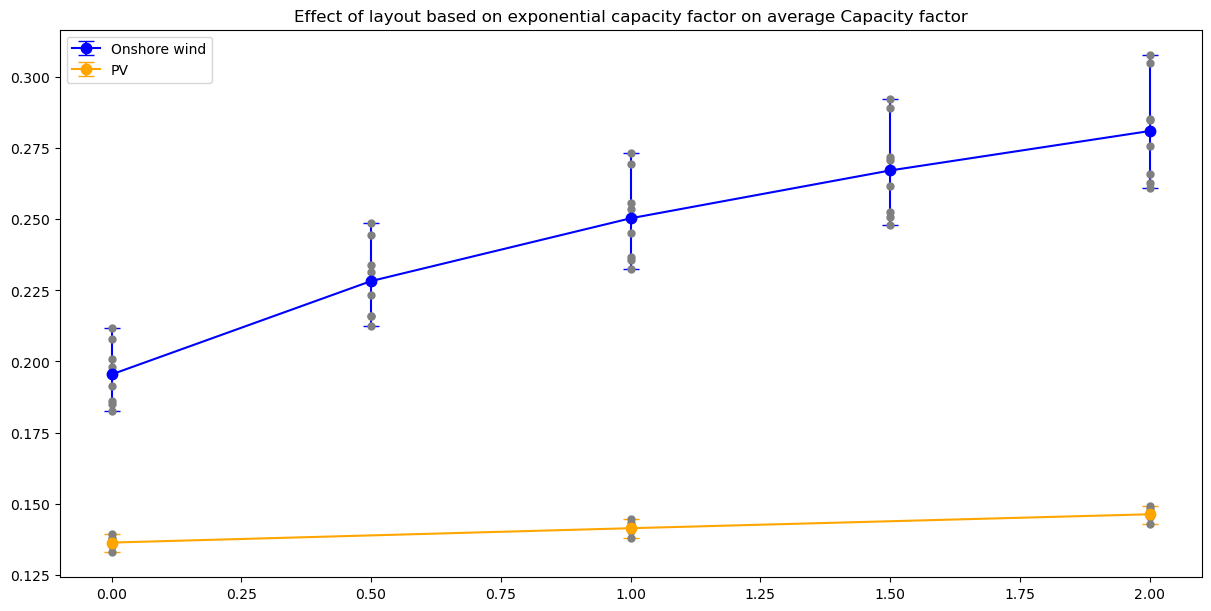

In [ ]:
fig_size = (12,6)
fig, ax = plt.subplots(figsize=fig_size, layout='constrained');

ax.errorbar(CF_mean_wind.index, averaged_CF.iloc[0], yerr=errors,linestyle='-', marker='.', markersize=15,capsize=6, label='Onshore wind', color='blue');
ax.plot(CF_mean_wind.index, CF_mean_wind, linestyle='None', marker='.', markersize=10, color='gray');

ax.errorbar(CF_mean_PV.index, averaged_CF_PV.iloc[0], yerr=errors_PV, linestyle='-', marker='.', markersize=15, capsize=6, label='PV', color='orange');
ax.plot(CF_mean_PV.index, CF_mean_PV, linestyle='None', marker='.', markersize=10, color='gray');
ax.legend();
ax.set_title('Effect of layout based on exponential capacity factor on average Capacity factor');
# plt.ylim(0, ) 

# Saving figure to file: 
plot_filename = (f'Effect of layout based on exponential capacity factor on average Capacity factor_2.png')
plt.savefig(plot_path(plot_filename), dpi=300)

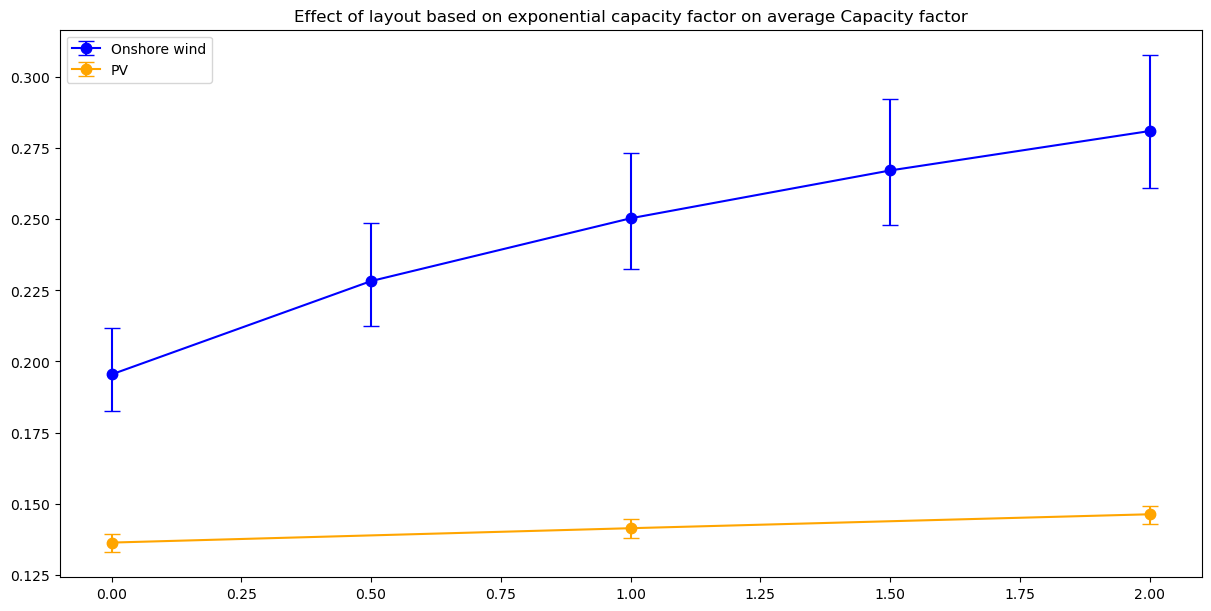

In [ ]:
fig, ax = plt.subplots(figsize=fig_size, layout='constrained');

ax.errorbar(CF_mean_wind.index, averaged_CF.iloc[0], yerr=errors,linestyle='-', marker='.', markersize=15,capsize=6, label='Onshore wind', color='blue');
# ax.plot(CF_mean_wind.index, CF_mean_wind, linestyle='None', marker='.', markersize=10, color='gray');

ax.errorbar(CF_mean_PV.index, averaged_CF_PV.iloc[0], yerr=errors_PV, linestyle='-', marker='.', markersize=15, capsize=6, label='PV', color='orange');
# ax.plot(CF_mean_PV.index, CF_mean_PV, linestyle='None', marker='.', markersize=10, color='gray');
ax.legend()

ax.set_title('Effect of layout based on exponential capacity factor on average Capacity factor');

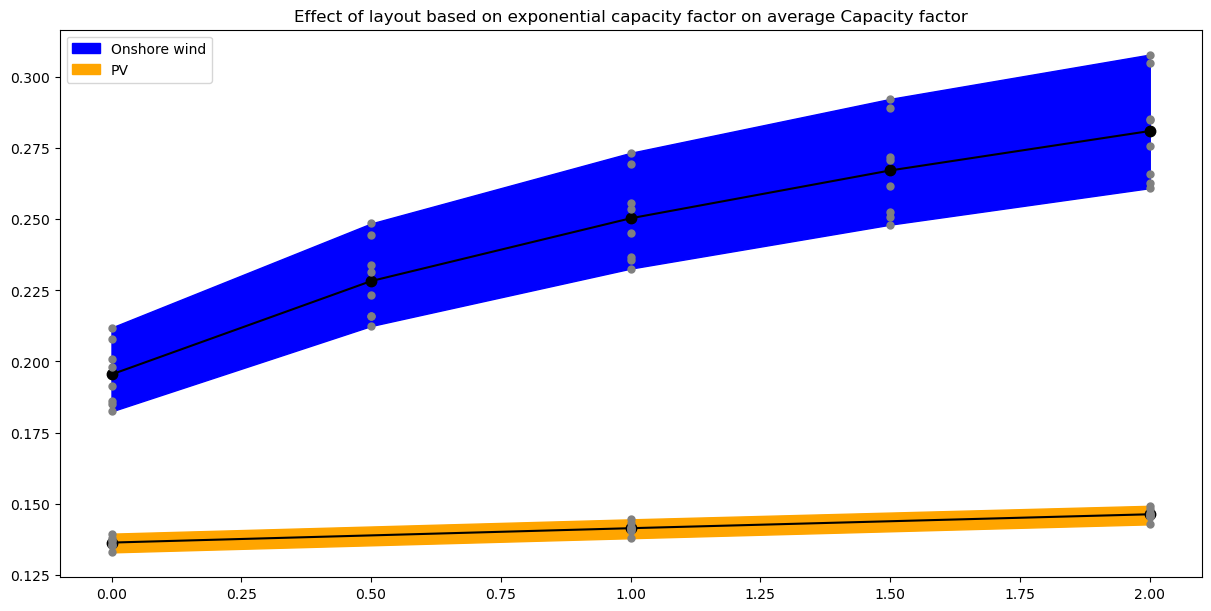

In [ ]:
fig, ax = plt.subplots(figsize=fig_size, layout='constrained');
ax.plot(CF_mean_wind.index, averaged_CF.iloc[0], marker='.', markersize=15, linestyle='-', color='k');
plt.fill_between(CF_mean_wind.index, averaged_CF.iloc[0]-errors[0], averaged_CF.iloc[0]+errors[1], label='Onshore wind', color='blue');
ax.plot(CF_mean_wind.index, CF_mean_wind, linestyle='None', marker='.', markersize=10, color='gray');

ax.plot(CF_mean_PV.index, averaged_CF_PV.iloc[0], marker='.', markersize=15, linestyle='-', color='k');
plt.fill_between(CF_mean_PV.index, averaged_CF_PV.iloc[0]-errors_PV[0], averaged_CF_PV.iloc[0]+errors_PV[1], label='PV', color='orange');
ax.plot(CF_mean_PV.index, CF_mean_PV, linestyle='None', marker='.', markersize=10, color='gray');

ax.legend();
ax.set_title('Effect of layout based on exponential capacity factor on average Capacity factor');

# Saving figure to file: 
plot_filename = (f'Effect of layout based on exponential capacity factor on average Capacity factor.png')
plt.savefig(plot_path(plot_filename), dpi=300)

# Processing data

In [ ]:
# Importing CSV file with area and installed capacity for each country

df = pd.read_csv('Countries-Europe.csv',delimiter=';')
Countries_europe = df.drop(['zoom','abbreviation','ISO numeric','population','latitude','longitude','continent'],axis=1).set_index('name',inplace=False).drop(['Vatican City','Monaco','Andorra','San Marino','Guernsey','Liechtenstein','Ukraine','Moldova','Belarus','Faroe Is.','Iceland','Gibraltar']).sort_values('name')

Countries_europe.rename(index={'Macedonia': 'North Macedonia'},inplace=True)


In [ ]:
# Combining the dataframes and calculating available area

# Countries_europe = pd.concat([Countries_europe, df_ratio], axis=1)
# Countries_europe.drop('Ratio of available area for PV',axis=1)
Countries_europe = pd.concat([Countries_europe, eligible_share], axis=1)
Countries_europe['Available area for PV'] = Countries_europe['Ratio of available area for PV']*Countries_europe['land area km']

# # Calculating unit capacity per km^2 to use in atlite
# Countries_europe['Unit PV capacity in 2015 [MW/km^2]'] = Countries_europe['PV capacity 2015 [MW]']/Countries_europe['Available area for PV']
# Countries_europe['Unit PV capacity in 2016 [MW/km^2]'] = Countries_europe['PV capacity 2016']/Countries_europe['Available area for PV']
# Countries_europe


In [ ]:
# # Calculating the area of each grid cell: 
# area = Europe_era5_16.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
# area = xr.DataArray(area, dims=("spatial"))

In [ ]:
# # New way of calculating the capacity matrix for 2016: 

# # Extracting the unit capacity from the csv table: 
# # cap_per_sqkm = Countries_europe['Unit PV capacity in 2016 [MW/km^2]']
# cap_per_sqkm = Countries_europe['Ratio of available area for PV'];

# # Predefining the capacity matrix Data Array: 
# capacity_matrix = A.stack(spatial=["y", "x"]) * area * 1

# # Calculating the capacity matrix for each country

# country = 'USA';
# for j in range(len(Countries_europe.index)): 
#    country = Europe_useful.index[j]; 
#    capacity_matrix[j] = A.stack(spatial=["y", "x"]).sel(dim_0=country) * area * cap_per_sqkm[country]


In [ ]:
# # New way of calculating the capacity matrix for 2015: 

# # Extracting the unit capacity from the csv table: 
# cap_per_sqkm_2015 = Countries_europe['Unit PV capacity in 2015 [MW/km^2]']

# # Predefining the capacity matrix Data Array: 
# capacity_matrix_2015 = A.stack(spatial=["y", "x"]) * area * 1

# # Calculating the capacity matrix for each country

# country = 'USA';
# for j in range(len(Countries_europe.index)): 
#     country = Europe_useful.index[j]; 
#     capacity_matrix_2015[j] = A.stack(spatial=["y", "x"]).sel(dim_0=country) * area * cap_per_sqkm_2015[country]
# #     capacity_matrix_2015[j] = A.stack(spatial=["y", "x"]).sel(dim_0=country) * area * cap_per_sqkm_2015[country] * Europe_era5_15.data['wnd100m'].stack(spatial=["y","x"]).mean(); 
    

In [ ]:
# coords_kwargs = A.stack(spatial=["y", "x"])
# Europe_era5_16.data['wnd100m'].stack(spatial=["y","x"]).assign_coords(coords=None,**coords_kwargs)
# Europe_era5_16.data['influx_toa']
# Europe_era5_16.data

## Generating cutouts based on new layout

In [ ]:
# # Getting onshore wind CF from Atlite for 2015 - 2022
# onshore_wind = Europe_era5_18_20.wind(
#     # matrix=capacity_matrix,
#     layout=proportional_layout_wind,
#     turbine=turbine,
#     index=Europe.index)

In [ ]:
# # Getting PV Atlite for 2015 - 2022
# pv = ERA5_final_cutout.pv(
#     # matrix=capacity_matrix,
#     layout=uniform_layout_PV,
#     panel=atlite.solarpanels.CSi,
#     orientation="latitude_optimal",
#     index=Europe.index)

## Plotting duration curves

In [ ]:
# Select country to plot: 
country = 'Italy';

# # Plot CF time series
# pv.sel(dim_0=country).to_pandas().div(Countries_europe['PV capacity 2016'][country]).plot(xlabel="Time",
#                                                                         ylabel="Capacity factor", figsize=(12, 5));
# prefix = 'Capacity factor time series for ';
# title = f'{prefix}{country}';
# plt.title(title);

NameError: name 'pv' is not defined

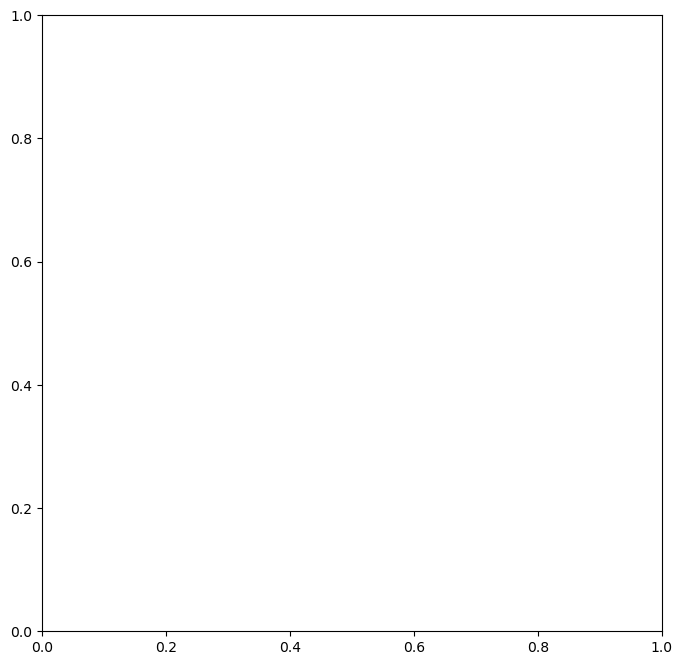

In [ ]:
# Sort the DataFrame by the loads, in descending order of magnitude

fig, ax = plt.subplots(figsize=(8, 8))

# Getting Atlite duration curve:
dur2 = pd.DataFrame(pv.sel(dim_0=country)/(Countries_europe['PV capacity 2016'][country])).sort_values(by=0,ascending = False)
title = 'Solar CF from Atlite';
dur_test = pd.DataFrame({title:dur2[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test['Interval'] = 1;
dur_test['Duration'] = dur_test['Interval'].cumsum();
dur_test['Percentage'] = dur_test['Duration']*100/len(dur_test);
dur_test.plot(ax=ax,x = 'Percentage', y = title,xlim=[-0.5,100]);

# Averaging ENTSO-E data over 1.4*maximum production: 
country_code = Countries_europe['ISO alpha 2'][country];
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}'
entso_e = (pd.DataFrame(opsd_16[opsd_name])/(PV_capacity['Est. PV capacity from production 2016'][country])).sort_values(by=opsd_name,ascending = False);
# Defining legend
start = 'Solar CF from ENTSO-E averaged over ';
end = '*maximum production';
title = f'{start}{p_factor}{end}';
dur_entsoe = pd.DataFrame({title:entso_e[opsd_name]});
dur_entsoe['Interval'] = 1;
dur_entsoe['Duration'] = dur_entsoe['Interval'].cumsum();
dur_entsoe['Percentage'] = dur_entsoe['Duration']*100/len(dur_entsoe);
dur_entsoe.plot(ax=ax, x = 'Percentage', y = title,ylabel="Capacity factor");

# Averaging ENTSO-E data over reported capacity
entso_e2 = (pd.DataFrame(opsd_16[opsd_name])/(PV_capacity['PV capacity 2016'][country])).sort_values(by=opsd_name,ascending = False);
title = 'Solar CF from ENTSO-E averaged over reported installed capacity';
dur_entsoe2 = pd.DataFrame({title:entso_e2[opsd_name]});
dur_entsoe2['Interval'] = 1;
dur_entsoe2['Duration'] = dur_entsoe2['Interval'].cumsum();
dur_entsoe2['Percentage'] = dur_entsoe2['Duration']*100/len(dur_entsoe2);
dur_entsoe2.plot(ax=ax,x = 'Percentage', y = title);

prefix = 'PV Duration curve for 2016 for ';
plt.title(f'{prefix}{country}');


## Comparing ENTSO-E data with ERA5 predictions
Comparing actual generation from ENTSO-E with the predictions from ERA5 (atlite)

In [ ]:
# Define country to compare Atlite with OPSD: 
country = 'Italy';

# Define date range for plots: 
start_date = '2016-05-10';
end_date = '2016-05-20';

country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}'
compare = (
    pd.DataFrame(
        dict(atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
#compare.plot(figsize=(10, 5))
compare.loc[start_date:end_date].plot(figsize=(10, 5));
plt.ylabel("Feed-In [GW]")
prefix = 'PV time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()

In [ ]:
# Weekly average plot

averaging_period = "1W";

start_date = '2016-01-01';
end_date = '2016-12-31';

compare_avg = compare.loc[start_date:end_date].resample(averaging_period).mean();
# compare.resample(averaging_period).mean().plot(figsize=(10, 5))
compare_avg.plot(figsize=(10, 5));
plt.ylabel("Feed-In [GW]")
prefix = 'Weekly averaged PV time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()


In [ ]:
# Calculating scaling factor for every country

averaging_period = "1W";

scale = pd.DataFrame(np.zeros(shape=[len(europe_list),2]),europe_list, 
                            columns=['Weekly PV Scaling factor 2016','Daily PV Scaling factor 2016'])

for i in europe_with_opsd_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_solar_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare = (
        pd.DataFrame(
            dict(atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
    compare_avg_week = compare.resample("1W").mean();
    compare_avg_day = compare.resample("1D").mean();
#     compare_avg_6H = compare.resample("8H").mean();
    scale.loc[[country],'Weekly PV Scaling factor 2016'] = (compare_avg_week['opsd'] / compare_avg_week['atlite']).mean();
    scale.loc[[country],'Daily PV Scaling factor 2016'] = (compare_avg_day['opsd'] / compare_avg_day['atlite']).mean();
#     scale.loc[[country],'Hourly PV Scaling factor'] = (compare_avg_6H['opsd'] / compare_avg_6H['atlite']).mean();
scale

In [ ]:
# Applying the scaling factor and comparing the results

# Define country to compare Atlite with OPSD: 
country = 'Netherlands';

start_date = '2016-06-20';
end_date = '2016-06-30';

country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}'
compare = (
        pd.DataFrame(
            dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),ENTSOE=opsd_16[opsd_name]))/1e3)    #in GW
# compare_avg_week = compare.resample("1W").mean();
compare = compare.loc[start_date:end_date];
compare.plot(figsize=(10, 5));

weekly_scaling_factor = scale.loc[[country],'Weekly PV Scaling factor 2016'][country];
daily_scaling_factor = scale.loc[[country],'Daily PV Scaling factor 2016'][country];
compare['Weekly corrected Atlite'] = compare[['Original_Atlite']] * weekly_scaling_factor;
compare['Weekly corrected Atlite'].plot(color='red', linestyle='dotted', label='Atlite corrected using week scale');
compare['Daily corrected Atlite'] = compare[['Original_Atlite']] * daily_scaling_factor;
compare['Daily corrected Atlite'].plot(color='green', linestyle='dashed', label='Atlite corrected using day scale');
plt.legend(['Atlite before correction', 
            'Production from ENTSO-E',
            'Atlite corrected using week scale',
            'Atlite corrected using day scale'])

plt.ylabel("Feed-In [GW]")
prefix = 'PV time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()

In [ ]:
# Weekly average plot

averaging_period = "1W";

start_date = '2016-01-01';
end_date = '2016-12-31';

compare = (
        pd.DataFrame(
            dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
compare = compare.loc[start_date:end_date];
compare_avg = compare.resample(averaging_period).mean();
compare_avg.plot(figsize=(10, 5));

weekly_scaling_factor = scale.loc[[country],'Weekly PV Scaling factor 2016'][country];
daily_scaling_factor = scale.loc[[country],'Daily PV Scaling factor 2016'][country];
compare['Weekly corrected Atlite'] = (compare[['Original_Atlite']] * weekly_scaling_factor)
compare_avg['Weekly corrected Atlite'] = compare['Weekly corrected Atlite'].resample(averaging_period).mean();
compare_avg['Weekly corrected Atlite'].plot(color='red', linestyle='dotted', label='Atlite corrected using week scale')

compare['Daily corrected Atlite'] = (compare[['Original_Atlite']] * daily_scaling_factor)
compare_avg['Daily corrected Atlite'] = compare['Daily corrected Atlite'].resample(averaging_period).mean();
compare_avg['Daily corrected Atlite'].plot(color='green', linestyle='dashed', label='Atlite corrected using day scale')


plt.legend()
plt.ylabel("Feed-In [GW]")
prefix = 'Weekly averaged PV time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()


In [ ]:
# Calculating offset for every country

averaging_period = "1W";

offset = pd.DataFrame(np.zeros(shape=[len(europe_list),2]),europe_list, 
                            columns=['Weekly PV offset 2016','Daily PV offset 2016'])

for i in europe_with_opsd_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_solar_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare = (
        pd.DataFrame(
            dict(atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
    compare_avg_week = compare.resample("1W").mean();
    compare_avg_day = compare.resample("1D").mean();
    offset.loc[[country],'Weekly PV offset 2016'] = (compare_avg_week['opsd'] - compare_avg_week['atlite']).mean();
    offset.loc[[country],'Daily PV offset 2016'] = (compare_avg_day['opsd'] - compare_avg_day['atlite']).mean();
offset

In [ ]:
# Applying the offset and comparing the results

# Define country to compare Atlite with OPSD: 
country = 'France';

start_date = '2016-06-25';
end_date = '2016-06-30';

country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}'
compare = (
        pd.DataFrame(
            dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
# compare_avg_week = compare.resample("1W").mean();
compare = compare.loc[start_date:end_date];
compare.plot(figsize=(10, 5));

weekly_offset = offset.loc[[country],'Weekly PV offset 2016'][country];
daily_offset = offset.loc[[country],'Daily PV offset 2016'][country];

compare['Weekly corrected Atlite'] = compare[['Original_Atlite']] + weekly_offset;
compare['Weekly corrected Atlite'].plot(color='red', linestyle='dotted', label='Atlite corrected using weekly offset');
compare['Daily corrected Atlite'] = compare[['Original_Atlite']] + daily_offset;
compare['Daily corrected Atlite'].plot(color='green', linestyle='dashed', label='Atlite corrected using daily offset');

plt.legend()

plt.ylabel("Feed-In [GW]")
prefix = 'PV time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()

In [ ]:
# Weekly average comparison plot

averaging_period = "1W";

start_date = '2016-01-01';
end_date = '2016-12-31';

compare = (
        pd.DataFrame(
            dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
compare = compare.loc[start_date:end_date];
compare_avg = compare.resample(averaging_period).mean();
compare_avg.plot(figsize=(12, 5));

weekly_offset = offset.loc[[country],'Weekly PV offset 2016'][country];
daily_offset = offset.loc[[country],'Daily PV offset 2016'][country];

compare['Weekly corrected Atlite'] = compare[['Original_Atlite']] + weekly_offset;
compare_avg['Weekly corrected Atlite'] = compare['Weekly corrected Atlite'].resample(averaging_period).mean();
compare_avg['Weekly corrected Atlite'].plot(color='green', linestyle='dashed', label='Atlite corrected using weekly offset')

compare['Daily corrected Atlite'] = compare[['Original_Atlite']] + daily_offset;
compare_avg['Daily corrected Atlite'] = compare['Daily corrected Atlite'].resample(averaging_period).mean();
compare_avg['Daily corrected Atlite'].plot(color='black', linestyle='dotted', label='Atlite corrected using daily offset',linewidth=2)

plt.legend(['Original Atlite','ENTSO-E','Atlite corrected using weekly offset','Atlite corrected using daily offset']);
plt.ylabel("Feed-In [GW]")
prefix = 'Weekly averaged PV time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()


## Calculating Normalized Root Mean Square Error

In [ ]:
# Normalized Root Mean Square Error for scale correction

#         MSE = np.square(np.subtract(actual,predicted)).mean()   
#         rmse = math.sqrt(MSE)

NRMSE = pd.DataFrame(np.zeros(shape=[len(europe_with_opsd_data),2]),europe_with_opsd_data, 
                                    columns=['NRMSE from weekly average correction','NRMSE from daily average correction'])

for i in europe_with_opsd_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_solar_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare = (
        pd.DataFrame(
            dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
#     compare = compare.loc[start_date:end_date];
    weekly_scaling_factor = scale.loc[[country],'Weekly PV Scaling factor 2016'][country];
    daily_scaling_factor = scale.loc[[country],'Daily PV Scaling factor 2016'][country];
    compare['Weekly corrected Atlite'] = (compare[['Original_Atlite']] * weekly_scaling_factor)
    compare['Daily corrected Atlite'] = (compare[['Original_Atlite']] * daily_scaling_factor)

    # Calculation using provided installed capacity 
    NRMSE.loc[[country],'NRMSE from weekly average correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
                                        compare['Weekly corrected Atlite'])).mean())/(Countries_europe['PV capacity 2016'][country]/10000);
    NRMSE.loc[[country],'NRMSE from daily average correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
                                        compare['Daily corrected Atlite'])).mean())/(Countries_europe['PV capacity 2016'][country]/10000);
# NRMSE   

In [ ]:
europe_with_opsd_data

In [ ]:
# # Plotting NRMSE per country

# width = 0.3;
# y_pos = np.arange(len(europe_with_opsd_data))

# f, ax = plt.subplots(figsize=(8,12))
# ax.set_yticks(y_pos, labels=europe_with_opsd_data)
# #br1 = np.arrange(len())
# ax.barh(y_pos-width/2, NRMSE['NRMSE from weekly average correction'],width,label='NRMSE from weekly average correction')
# ax.barh(y_pos + width/2, NRMSE['NRMSE from daily average correction'],width,label='NRMSE from daily average correction')
# ax.invert_yaxis()
# ax.set_xlabel('NRMSE')
# ax.set_title('Normalized Root mean square error for SCALE correction')
# plt.legend()
# plt.xlim([0,2.9])

# for i in ax.patches:
#     plt.text(i.get_width()+0.01, i.get_y()+width,
#              str(round((i.get_width()), 3)),
#              fontsize = 8, fontweight ='normal',
#              color ='grey')

 Conclusion: Daily average correction is better as it yields lower NRMSE values

In [ ]:
# Root mean square error for offset correction

#         MSE = np.square(np.subtract(actual,predicted)).mean()   

#         rmse = math.sqrt(MSE)
NRMSE_offset = pd.DataFrame(np.zeros(shape=[len(europe_with_opsd_data),2]),europe_with_opsd_data, 
                                      columns=['NRMSE from weekly average correction','NRMSE from daily average correction'])

for i in europe_with_opsd_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_solar_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare = (
        pd.DataFrame(
            dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
#     compare = compare.loc[start_date:end_date];
    weekly_offset = offset.loc[[country],'Weekly PV offset 2016'][country];
    daily_offset = offset.loc[[country],'Daily PV offset 2016'][country];
    compare['Weekly corrected Atlite'] = (compare[['Original_Atlite']] + weekly_offset)
    compare['Daily corrected Atlite'] = (compare[['Original_Atlite']] + daily_offset)

    #RMSE_offset.loc[[country],'RMSE from weekly average correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),compare['Weekly corrected Atlite'])).mean());
    #RMSE_offset.loc[[country],'RMSE from daily average correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),compare['Daily corrected Atlite'])).mean());
     # Calculation using provided installed capacity 
    NRMSE_offset.loc[[country],'NRMSE from weekly average correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
                        compare['Weekly corrected Atlite'])).mean())/(Countries_europe['PV capacity 2016'][country]/10000);
    NRMSE_offset.loc[[country],'NRMSE from daily average correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
                        compare['Daily corrected Atlite'])).mean())/(Countries_europe['PV capacity 2016'][country]/10000);
# NRMSE

In [ ]:
# # Plotting NRMSE per country

# width = 0.3;
# y_pos = np.arange(len(europe_with_opsd_data))

# f, ax = plt.subplots(figsize=(8,12))
# ax.set_yticks(y_pos, labels=europe_with_opsd_data)
# #br1 = np.arrange(len())
# ax.barh(y_pos-width/2, NRMSE_offset['NRMSE from weekly average correction'],width,label='NRMSE from weekly average correction')
# ax.barh(y_pos + width/2, NRMSE_offset['NRMSE from daily average correction'],width,label='NRMSE from daily average correction')
# ax.invert_yaxis()
# ax.set_xlabel('RMSE')
# ax.set_title('Normalized Root mean square error for OFFSET correction')
# plt.legend()
# plt.xlim([0,1.5])

# for i in ax.patches:
#     plt.text(i.get_width()+0.05, i.get_y()+width,
#              str(round((i.get_width()), 3)),
#              fontsize = 8, fontweight ='normal',
#              color ='grey')

In [ ]:
# Plotting RMSE per country

width = 0.22;
y_pos = np.arange(len(europe_with_opsd_data))

f, ax = plt.subplots(figsize=(8,14))
ax.set_yticks(y_pos, labels=europe_with_opsd_data)

ax.barh(y_pos - 1.5*width, NRMSE['NRMSE from weekly average correction'],width,label='Scale NRMSE from weekly average correction')
ax.barh(y_pos - width/2, NRMSE['NRMSE from daily average correction'],width,label='Scale NRMSE from daily average correction')
ax.barh(y_pos + width/2, NRMSE_offset['NRMSE from weekly average correction'],width,label='Offset NRMSE from weekly average correction')
ax.barh(y_pos + 1.5*width, NRMSE_offset['NRMSE from daily average correction'],width,label='Offset NRMSE from daily average correction')
ax.invert_yaxis()
ax.set_xlabel('NRMSE')
ax.set_title('Normalized Root mean square error comparison')
plt.legend()
plt.xlim([0,1.6])
plt.grid(axis='x')

for i in ax.patches:
    plt.text(i.get_width()+0.05, i.get_y()+width,
             str(round((i.get_width()), 3)),
             fontsize = 8, fontweight ='normal',
             color ='grey')
    

In [ ]:
# Weekly average plot

averaging_period = "1W";

start_date = '2016-01-01';
end_date = '2016-12-31';

compare = (
        pd.DataFrame(
            dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
compare = compare.loc[start_date:end_date];
compare_avg = compare.resample(averaging_period).mean();
compare_avg.plot(figsize=(10, 5));

scaling_factor = scale.loc[[country],'Average PV Scaling factor'][country];
compare['Scale corrected Atlite'] = (compare[['Original_Atlite']] * weekly_scaling_factor)
compare_avg['Scale corrected Atlite'] = compare['Scale corrected Atlite'].resample(averaging_period).mean();
compare_avg['Scale corrected Atlite'].plot(color='red', linestyle='dotted', 
                                           label='Atlite corrected using averaged scaling factor')

plt.legend()
plt.ylabel("Feed-In [GW]")
prefix = 'Weekly averaged PV time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()


In [ ]:
# Plotting updated duration curve

# Select country to plot: 
# country = 'Italy';

fig, ax = plt.subplots(figsize=(12, 5))

# Getting Atlite duration curve 2015:
dur2 = pd.DataFrame(pv_2015.sel(dim_0=country)/(Countries_europe['PV capacity 2015 [MW]'][country])).sort_values(by=0,ascending = False)
title = 'Solar CF in 2015 from original Atlite (before correction)';
dur_test = pd.DataFrame({title:dur2[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test['Interval'] = 1;
dur_test['Duration'] = dur_test['Interval'].cumsum();
dur_test['Percentage'] = dur_test['Duration']*100/len(dur_test);
dur_test.plot(ax=ax,x = 'Percentage', y = title,xlim=[-0.5,100],figsize=(12,6));

# Getting Atlite duration curve 2016:
dur2 = pd.DataFrame(pv.sel(dim_0=country)/(Countries_europe['PV capacity 2016'][country])).sort_values(by=0,ascending = False)
title = 'Solar CF in 2016 from original Atlite (before correction)';
dur_test = pd.DataFrame({title:dur2[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test['Interval'] = 1;
dur_test['Duration'] = dur_test['Interval'].cumsum();
dur_test['Percentage'] = dur_test['Duration']*100/len(dur_test);
dur_test.plot(ax=ax,x = 'Percentage', y = title);

# Averaging ENTSO-E data over reported capacity 2015
country_code = Countries_europe['ISO alpha 2'][country];
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}'
entso_e3 = (pd.DataFrame(opsd_15[opsd_name])/
            (Countries_europe['PV capacity 2015 [MW]'][country])).sort_values(by=opsd_name,ascending=False);
title = 'Solar CF from ENTSO-E in 2015';
dur_entsoe3 = pd.DataFrame({title:entso_e3[opsd_name]});
dur_entsoe3['Interval'] = 1;
dur_entsoe3['Duration'] = dur_entsoe3['Interval'].cumsum();
dur_entsoe3['Percentage'] = dur_entsoe3['Duration']*100/len(dur_entsoe3);
dur_entsoe3.plot(ax=ax,x = 'Percentage', y = title);

# Averaging ENTSO-E data over reported capacity 2016
country_code = Countries_europe['ISO alpha 2'][country];
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}'
entso_e2 = (pd.DataFrame(opsd_16[opsd_name])/
            (Countries_europe['PV capacity 2016'][country])).sort_values(by=opsd_name,ascending=False);
title = 'Solar CF from ENTSO-E in 2016';
dur_entsoe2 = pd.DataFrame({title:entso_e2[opsd_name]});
dur_entsoe2['Interval'] = 1;
dur_entsoe2['Duration'] = dur_entsoe2['Interval'].cumsum();
dur_entsoe2['Percentage'] = dur_entsoe2['Duration']*100/len(dur_entsoe2);
dur_entsoe2.plot(ax=ax,x = 'Percentage', y = title);

# Plotting corrected Atlite: 
dur3_0 = pd.DataFrame((pv.sel(dim_0=country)/(Countries_europe['PV capacity 2016'][country])) + 
                      (np.ones((len(pv.sel(dim_0=country)),), dtype=int)*
                       (offset.loc[[country],'Normalized averaged PV offset'][country]/1e3)))
dur3 = pd.DataFrame(dur3_0).sort_values(by=0,ascending = False);       
title2 = 'Solar CF from corrected Atlite (after offset correction)';
dur_test2 = pd.DataFrame({title2:dur3[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test2['Interval'] = 1;
dur_test2['Duration'] = dur_test2['Interval'].cumsum();
dur_test2['Percentage'] = dur_test2['Duration']*100/len(dur_test2);
dur_test2.plot(ax=ax,x = 'Percentage', y = title2,linestyle='dotted');

# Plotting corrected Atlite using scale: 
dur3_0 = pd.DataFrame((pv.sel(dim_0=country)*
                     (np.ones((len(pv.sel(dim_0=country)),), dtype=int)/(Countries_europe['PV capacity 2016'][country])))*
                     (scale.loc[[country],'Average PV Scaling factor'][country]))
                      
dur3 = pd.DataFrame(dur3_0).sort_values(by=0,ascending = False);       
title2 = 'Solar CF from corrected Atlite (after scale correction)';
dur_test2 = pd.DataFrame({title2:dur3[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test2['Interval'] = 1;
dur_test2['Duration'] = dur_test2['Interval'].cumsum();
dur_test2['Percentage'] = dur_test2['Duration']*100/len(dur_test2);
dur_test2.plot(ax=ax,x = 'Percentage', y = title2, linestyle='dashed');

prefix = 'PV Duration curve for 2015 and 2016 for ';
plt.title(f'{prefix}{country}');
plt.grid()

In [ ]:
Europe_df = gpd.GeoDataFrame(Europe)
Europe_df['Average PV Scaling factor'] = scale['Average PV Scaling factor'];
Europe_df['Normalized averaged PV offset'] = offset['Normalized averaged PV offset'];
Europe_df.rename(columns ={0:'geometry'},inplace=True);
Europe_df.set_geometry('geometry',crs={"init": "epsg:4326"});

In [ ]:
max1 = np.nanmax(Europe_df['Average PV Scaling factor'])+0.1;
min1 = np.nanmin(Europe_df['Average PV Scaling factor']);
Europe_df['Average PV Scaling factor'].replace(0, np.nan, inplace=True)

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))

z = np.linspace(0,1,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=z.mean(), vmax=z.max())

fix, ax = plt.subplots(figsize=(12,12))
Europe_df.plot(ax=ax, column="Average PV Scaling factor", cmap="Oranges", legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
plt.title('Scaling factor for solar production for countries with ENTSO-E data');

In [ ]:
# Calculating scaling factors for missing countries

balkan_countries_missing = ['Croatia', 'Albania','Montenegro','Bosnia and Herzegovina',
                            'North Macedonia','Kosovo','Serbia','Hungary']
countries = ['Italy', 'Slovakia', 'Bulgaria', 'Greece', 'Romania', 'Austria','Slovenia'];
Europe_df['Average PV Scaling factor'][balkan_countries_missing] = Europe_df['Average PV Scaling factor'][countries].mean()

Poland_neighbours = ['Slovakia', 'Czech Republic', 'Germany', 'Lithuania']
Europe_df['Average PV Scaling factor']['Poland'] = Europe_df['Average PV Scaling factor'][Poland_neighbours].mean()

Ireland_neighbours = ['United Kingdom']
Europe_df['Average PV Scaling factor']['Ireland'] = Europe_df['Average PV Scaling factor'][Ireland_neighbours].mean()

Luxembourg_neighbours = ['France', 'Belgium', 'Germany']
Europe_df['Average PV Scaling factor']['Luxembourg'] = Europe_df['Average PV Scaling factor'][Luxembourg_neighbours].mean()

Europe_df['Average PV Scaling factor']['Latvia'] = Europe_df['Average PV Scaling factor']['Lithuania']
Europe_df['Average PV Scaling factor']['Estonia'] = Europe_df['Average PV Scaling factor']['Lithuania']

nordics = ['Norway', 'Sweden', 'Finland']
nordics_neighbours = ['United Kingdom', 'Denmark', 'Lithuania', 'Latvia', 'Estonia']
Europe_df['Average PV Scaling factor'][nordics] = Europe_df['Average PV Scaling factor'][nordics_neighbours].mean()


In [ ]:
max1 = np.nanmax(Europe_df['Average PV Scaling factor'])+0.1;
min1 = np.nanmin(Europe_df['Average PV Scaling factor']);

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))

z = np.linspace(0,1,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=z.mean(), vmax=z.max())

fix, ax = plt.subplots(figsize=(12,12))
Europe_df.plot(ax=ax, column="Average PV Scaling factor", cmap="Oranges", legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal").set_frame_on(False);
Europe.plot(ax=ax, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
plt.title('Scaling factor for solar for all countries');
plt.axis(False);


In [ ]:
max1 = np.nanmax(Europe_df['Normalized averaged PV offset'])+8;
min1 = np.nanmin(Europe_df['Normalized averaged PV offset'])-1;
Europe_df['Normalized averaged PV offset'].replace(0, np.nan, inplace=True)

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))

z = np.linspace(min1,0,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=z.mean(), vmax=z.max())
fix, ax = plt.subplots(figsize=(12,12))
Europe_df.plot(ax=ax, column="Normalized averaged PV offset", legend=True,legend_kwds={'shrink': 0.5},cmap="Blues_r",
               norm=norm,aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
plt.title('Solar normalized offset');
plt.axis(False);

In [ ]:
# Calculating annual production 
total_production = pd.DataFrame(np.zeros(shape=[len(europe_list),10]),europe_list, 
                            columns=['Atlite after correction in 2015',
                                     'Atlite after correction in 2016',
                                     'Atlite after offset correction in 2015',
                                     'Atlite after offset correction in 2016',
                                     'ENTSO-E 2015',
                                     'ENTSO-E 2016', 
                                     'Difference in 2015 [%]',
                                     'Difference in 2016 [%]',
                                     'Offset difference in 2015 [%]',
                                     'Offset difference in 2016 [%]'])

for country in europe_with_opsd_data:
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_solar_generation_actual'
    opsd_name = f'{country_code}{suffix}';
    scaling_factor = Europe_df.loc[[country],'Average PV Scaling factor'][country];
    offset_factor_2015 = Europe_df.loc[[country],'Normalized averaged PV offset'][country]*(Countries_europe['PV capacity 2015 [MW]'][country])/1e6;
    offset_factor_2016 = Europe_df.loc[[country],'Normalized averaged PV offset'][country]*(Countries_europe['PV capacity 2016'][country])/1e6;
    total_production['Atlite after correction in 2015'][country] = ((pv_2015.sel(dim_0=country).squeeze().to_series() * scaling_factor).sum())/1e3   #in GW
    total_production['Atlite after correction in 2016'][country] = ((pv.sel(dim_0=country).squeeze().to_series() * scaling_factor).sum())/1e3   #in GW
    total_production['Atlite after offset correction in 2015'][country] = ((pv_2015.sel(dim_0=country).squeeze().to_series() + offset_factor_2015).sum())/1e3   #in GW
    total_production['Atlite after offset correction in 2016'][country] = ((pv.sel(dim_0=country).squeeze().to_series() + offset_factor_2016).sum())/1e3   #in GW
    total_production['ENTSO-E 2015'][country] = opsd=(opsd_15[opsd_name]/1e3).sum()
    total_production['ENTSO-E 2016'][country] = opsd=(opsd_16[opsd_name]/1e3).sum()
    total_production['Difference in 2015 [%]'][country] = (total_production['Atlite after correction in 2015'][country] / total_production['ENTSO-E 2015'][country])*100 - 100;
    total_production['Difference in 2016 [%]'][country] = (total_production['Atlite after correction in 2016'][country] / total_production['ENTSO-E 2016'][country])*100 - 100;
    total_production['Offset difference in 2015 [%]'][country] = (total_production['Atlite after offset correction in 2015'][country] / total_production['ENTSO-E 2015'][country])*100 - 100;
    total_production['Offset difference in 2016 [%]'][country] = (total_production['Atlite after offset correction in 2016'][country] / total_production['ENTSO-E 2016'][country])*100 - 100;
    
# Fixing Italy:
country = 'Italy';
country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}';

start_date = '2015-10-01';
end_date = '2015-12-31';

total_production['Atlite after correction in 2015'][country] = ((pv_2015.sel(dim_0=country).loc[start_date:end_date].squeeze().to_series() * scaling_factor).sum())/1e3   #in GW
total_production['Atlite after offset correction in 2015'][country] = ((pv_2015.sel(dim_0=country).loc[start_date:end_date].squeeze().to_series() + offset_factor_2015).sum())/1e3   #in GW
total_production['ENTSO-E 2015'][country] = opsd=(opsd_15[opsd_name]/1e3).sum()
total_production['Difference in 2015 [%]'][country] = (total_production['Atlite after correction in 2015'][country] / total_production['ENTSO-E 2015'][country])*100 - 100;
total_production['Offset difference in 2015 [%]'][country] = (total_production['Atlite after offset correction in 2015'][country] / total_production['ENTSO-E 2015'][country])*100 - 100;

total_production

In [ ]:
# Plotting the difference
total_production_plot = total_production.drop(['Albania','Bosnia and Herzegovina','Estonia','Poland','Hungary','Croatia',
                                                     'Cyprus','Finland','Ireland','Kosovo','Latvia',
                                                     'Luxembourg','North Macedonia','Malta','Montenegro',
                                                     'Norway','Serbia','Sweden'],axis=0,inplace=False)
width = 0.22;
y_pos = np.arange(len(total_production_plot))

f, ax = plt.subplots(figsize=(8,8))
ax.set_yticks(y_pos, labels=europe_with_opsd_data)
#br1 = np.arrange(len())
ax.barh(y_pos - width/2, abs(total_production_plot['Difference in 2015 [%]']),width,label='Scale correction')
ax.barh(y_pos + width/2, abs(total_production_plot['Offset difference in 2015 [%]']),width,label='Offset correction')
ax.invert_yaxis()
ax.set_xlabel('Difference compared to recorded annual production [%]')
ax.set_title('Annual production difference comparison for year 2015')
plt.legend(loc='center right')
plt.xlim([0,100])
plt.grid(axis='x')

for i in ax.patches:
    plt.text(i.get_width()+2, i.get_y()+width,
             str(round((i.get_width()), 2)),
             fontsize = 9, fontweight ='normal',
             color ='grey')
    

In [ ]:
# Plotting the difference
total_production_plot = total_production.drop(['Albania','Bosnia and Herzegovina','Estonia','Poland','Hungary','Croatia',
                                                     'Cyprus','Finland','Ireland','Kosovo','Latvia',
                                                     'Luxembourg','North Macedonia','Malta','Montenegro',
                                                     'Norway','Serbia','Sweden'],axis=0,inplace=False)
width = 0.3;
y_pos = np.arange(len(total_production_plot))

f, ax = plt.subplots(figsize=(8,8))
ax.set_yticks(y_pos, labels=europe_with_opsd_data)
#br1 = np.arrange(len())
ax.barh(y_pos - width/2, abs(total_production_plot['Difference in 2016 [%]']),width,label='Scale correction')
ax.barh(y_pos + width/2, abs(total_production_plot['Offset difference in 2016 [%]']),width,label='Offset correction')
ax.invert_yaxis()
ax.set_xlabel('Difference compared to recorded annual production [%]')
ax.set_title('Error in corrected annual PV production from Atlite compared to ENTSO-E data for year 2016')
plt.legend(loc='center right')
plt.xlim([0,45])
plt.grid(axis='x')

for i in ax.patches:
    plt.text(i.get_width()+1.1, i.get_y()+width,
             str(round((i.get_width()), 2)),
             fontsize = 9, fontweight ='normal',
             color ='gray')
# plot.set_frame_on(False)

In [ ]:
# Average scale error for 2015:
abs(total_production_plot.drop('Italy',axis=0,inplace=False))['Difference in 2015 [%]'].mean()

In [ ]:
# Average scale error for 2016:
abs(total_production_plot['Difference in 2016 [%]']).mean()

In [ ]:
# Average offset error for 2015:
abs(total_production_plot['Offset difference in 2015 [%]']).mean()

In [ ]:
# Average offset error for 2016:
abs(total_production_plot['Offset difference in 2016 [%]']).mean()

In [ ]:
# import statistics
country = 'Germany';

country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_solar_generation_actual'
opsd_name = f'{country_code}{suffix}';

averaging_period = "1H"

start_date = '2016-01-01';
end_date = '2016-12-31';

compare = (pd.DataFrame(dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),
                          opsd=opsd_16[opsd_name]))/1e3)    #in GW
compare = compare.loc[start_date:end_date];
scaling_factor = scale.loc[[country],'Average PV Scaling factor'][country];
weekly_offset = offset.loc[[country],'Normalized averaged PV offset'][country]*Countries_europe.loc[[country],
                                                                                'PV capacity 2016'][country]/1e6;

compare['Weekly corrected Atlite'] = compare[['Original_Atlite']] + weekly_offset;
compare['Scale corrected Atlite'] = compare[['Original_Atlite']] * scaling_factor;
compare_avg = compare.resample(averaging_period).mean();
compare_avg['Original_Atlite'].plot(figsize=(12, 5));
compare_avg['opsd'].plot();
compare_avg['Weekly corrected Atlite'].plot(linestyle='dotted')
compare_avg['Scale corrected Atlite'].plot(color='green', linestyle='dashed');
plt.legend(['Original Atlite', 
            'Production data from ENTSO-E', 
            'Atlite corrected using offset', 
            'Atlite corrected using scale'])
plt.ylabel("Feed-In [GW]")
prefix = 'Monthly averaged PV production comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()
plt.grid()
# st_dev_1 = np.sqrt(sum(compare['Scale corrected Atlite'] - compare['Original_Atlite'])**2 / len(compare))
# st_dev_1

In [ ]:
st_dev_2 = np.sqrt(sum(compare['opsd'] - compare['Original_Atlite'])**2 / len(compare))
st_dev_2

In [ ]:
# Calculating ramps

# start_date = '2016-01-01';
start_date = '2016-06-01';
end_date = '2016-06-30';
# end_date = '2016-12-31';

compare = (pd.DataFrame(dict(Original_Atlite=pv.sel(dim_0=country).squeeze().to_series(),
                          opsd=opsd_16[opsd_name]))/1e3)    #in GW
compare = compare.loc[start_date:end_date];
scaling_factor = scale.loc[[country],'Average PV Scaling factor'][country];
weekly_offset = offset.loc[[country],'Normalized averaged PV offset'][country]*Countries_europe.loc[[country],
                                                                                'PV capacity 2016'][country]/1e6;

compare['Weekly corrected Atlite'] = compare[['Original_Atlite']] + weekly_offset;
compare['Scale corrected Atlite'] = compare[['Original_Atlite']] * scaling_factor;
compare = compare.diff()
compare_avg = compare.resample(averaging_period).mean();
compare_avg['Original_Atlite'].plot(figsize=(12,5));
compare_avg['opsd'].plot();
plt.legend(['Original Atlite',
            'ENTSO-E data']);
plt.ylabel("Ramp")
prefix = 'Distribution of ramps for PV production in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()
plt.grid()

C:\Users\c10si\AppData\Local\Temp\ipykernel_16160\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_16160\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_16160\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local\Temp\ipykernel_16160\185959979.py:10: RuntimeWarning: overflow encountered in scalar multiply
  eligible_share_wind.loc[[i]] = masked.sum() * excluder_wind.res**2 / Europe_useful_wind.loc[[i]].geometry.item().area
C:\Users\c10si\AppData\Local

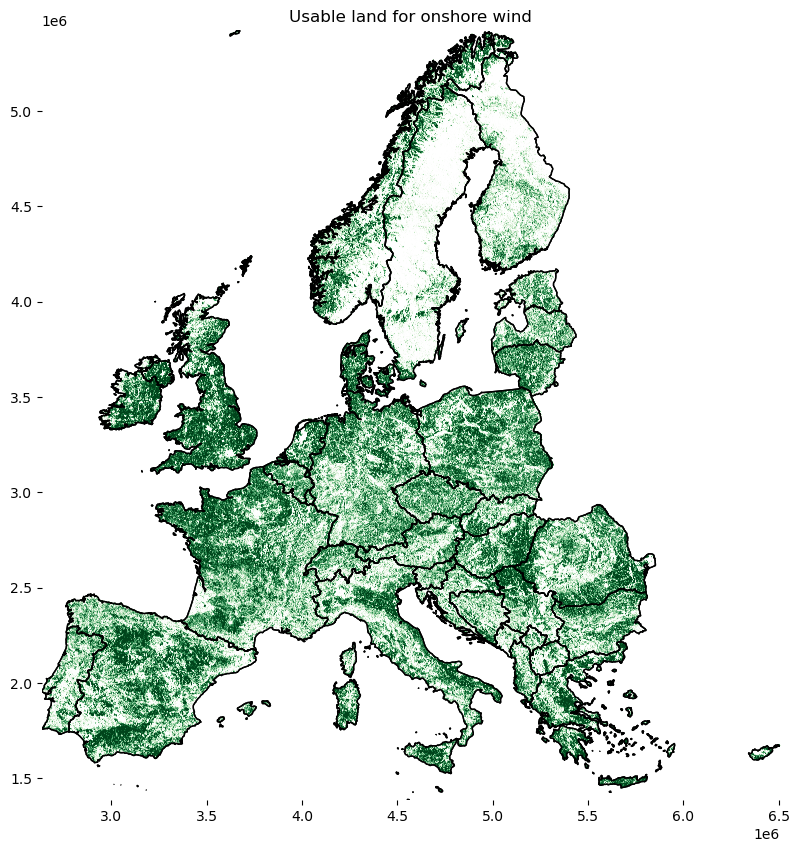

Compute availability matrix: 100%|██████████| 36/36 [01:11<00:00,  1.99s/ gridcells]


In [ ]:
# Removing countries without onshore wind generation data

europe_with_wind_data = Countries_europe.index.drop(['Albania','Bosnia and Herzegovina','Montenegro','Slovenia','Croatia',
                                                     'Kosovo','Luxembourg','North Macedonia','Malta','Serbia','Slovakia',
                                                     'Switzerland'])
europe_with_wind_data

# Verifying installed onshore wind capacity

In [ ]:
p_factor = 1.2;  # Scaling factor multipliying the yearly maximum production to estimate installed capacity
Wind_capacity = pd.DataFrame(index=Countries_europe.index)
Wind_capacity['Wind power capacity 2015'] = Countries_europe['Wind power capacity 2015'];
Wind_capacity['Wind power capacity 2016'] = Countries_europe['Wind power capacity 2016'];
Wind_capacity['Est. wind capacity from production 2015'] = 0;
Wind_capacity['Est. wind capacity from production 2016'] = 0;
for i in europe_with_wind_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_wind_onshore_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    Wind_capacity['Est. wind capacity from production 2015'][country] = p_factor*np.nanmax(opsd_15[opsd_name])
    Wind_capacity['Est. wind capacity from production 2016'][country] = p_factor*np.nanmax(opsd_16[opsd_name])
Wind_capacity

In [ ]:
# Combining the dataframes and calculating available area
# Countries_europe = pd.concat([Countries_europe, df_ratio], axis=1)
# Countries_europe.drop('Ratio of available area for onshore wind',axis=1,inplace=True)
Countries_europe = pd.concat([Countries_europe, eligible_share_wind], axis=1);
Countries_europe['Available area for onshore wind'] = (Countries_europe['Ratio of available area for onshore wind']*Countries_europe['land area km']);

# Adding missing data: (source: windEurope.org)
Countries_europe['Wind power capacity 2015']['Ireland'] = 2446;
Countries_europe['Wind power capacity 2016']['Ireland'] = 2830;

# Calculating unit capacity per km^2 to use in atlite
Countries_europe['Unit onshore wind capacity in 2015 [MW/km^2]'] = Countries_europe['Wind power capacity 2015']/Countries_europe['Available area for onshore wind']
Countries_europe['Unit onshore wind capacity in 2016 [MW/km^2]'] = Countries_europe['Wind power capacity 2016']/Countries_europe['Available area for onshore wind']

Countries_europe


In [ ]:
# Subplots 

Countries_europe_df = gpd.GeoDataFrame(Europe)
Countries_europe_df['Ratio of available area for PV'] = Countries_europe['Ratio of available area for PV']*100;
Countries_europe_df['Ratio of available area for onshore wind'] = Countries_europe['Ratio of available area for onshore wind']*100;
# Countries_europe_df['Normalized averaged PV offset'] = offset['Normalized averaged PV offset'];
Countries_europe_df.rename(columns ={0:'geometry'},inplace=True);
min_tot = min(Countries_europe_df['Ratio of available area for PV'])
max_tot = max(Countries_europe_df['Ratio of available area for onshore wind'])
Countries_europe_df.set_geometry('geometry',crs={"init": "epsg:4326"});

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,9))
plt.subplots_adjust(wspace=0)

# Plot 1 - PV
Countries_europe_df.plot(ax=ax1, column="Ratio of available area for PV",cmap="Greens",vmin=min_tot,vmax = max_tot, legend=False,legend_kwds={'shrink': 0.5},
               aspect="equal").set_frame_on(False);
Countries_europe_df.plot(ax=ax1, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
ax1.set_title('Percentage of land available for PV production');
ax1.axis(False)
plt.axis(False);

# Plot 2 - wind
Countries_europe_df.plot(ax=ax2, column="Ratio of available area for onshore wind",vmin=min_tot,vmax = max_tot, cmap="Greens",legend=False,legend_kwds={'shrink': 0.5},
               aspect="equal").set_frame_on(False);
Countries_europe_df.plot(ax=ax2, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
plt.title('Percentage of land available for onshore wind production');
plt.axis(False);

# addidng colorbar
norm = mpl.colors.Normalize(vmin = min_tot, vmax = max_tot);
cax = fig.add_axes([0.2, 0.22, 0.6, 0.03]);
fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap = 'Greens'),cax = cax,
             orientation='horizontal',label='Percentage of available land [%]');


In [ ]:
# Calculating the area of each grid cell: 
area = Europe_era5_16.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

In [ ]:
# Calculating the capacity matrix: 

# Extracting the unit capacity from the csv table: 
cap_per_sqkm_wind = Countries_europe['Unit onshore wind capacity in 2016 [MW/km^2]']

# Predefining the capacity matrix Data Array: 
capacity_matrix_wind = A_wind.stack(spatial=["y", "x"]) * area * 1

# Calculating the capacity matrix for each country

country = 'USA';
for j in range(len(Countries_europe.index)): 
   country = Europe_useful.index[j]; 
   capacity_matrix_wind[j] = A_wind.stack(spatial=["y", "x"]).sel(dim_0=country) * area * cap_per_sqkm_wind[country]

    
# Calculating the capacity matrix for 2015: 

# Extracting the unit capacity from the csv table: 
cap_per_sqkm_wind_2015 = Countries_europe['Unit onshore wind capacity in 2015 [MW/km^2]']

# Predefining the capacity matrix Data Array: 
capacity_matrix_wind_2015 = A_wind.stack(spatial=["y", "x"]) * area * 1

# Calculating the capacity matrix for each country

country = 'USA';
for j in range(len(Countries_europe.index)): 
    country = Europe_useful.index[j]; 
    capacity_matrix_wind_2015[j] = A_wind.stack(spatial=["y", "x"]).sel(dim_0=country) * area * cap_per_sqkm_wind_2015[country]
#     capacity_matrix_2015[j] = A.stack(spatial=["y", "x"]).sel(dim_0=country) * area * cap_per_sqkm_wind_2015[country] * Europe_era5_15.data['wnd100m'].mean(); 
    

In [ ]:
# Europe_era5_15.data['wnd100m']

In [ ]:
# Defining shape of European countries

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
Europe = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
#).reindex(["Austria","Denmark","Germany","Italy"])
).reindex(europe_list)

# Removing extra territories (islands in the Atlantic, etc.)
mask = (-11, 30, 50, 74)
Europe = Europe.clip(mask)

In [ ]:
# Europe_era5_16.prepare()
onshore_wind = Europe_era5_16.wind(
    matrix=capacity_matrix_wind,
    turbine='Vestas_V112_3MW',
    index=Europe.index)

onshore_wind_2015 = Europe_era5_15.wind(
    matrix=capacity_matrix_wind_2015,
    turbine='Vestas_V112_3MW',
    index=Europe.index)

In [ ]:
# Define country to compare Atlite with OPSD: 
country = 'Switzerland';

# Define date range for plots: 
start_date = '2015-05-01';
end_date = '2015-05-30';

country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_wind_onshore_generation_actual'
opsd_name = f'{country_code}{suffix}'
compare = (
    pd.DataFrame(
        dict(atlite=onshore_wind_2015.sel(dim_0=country).squeeze().to_series(),opsd=opsd_15[opsd_name]))/1e3)    #in GW

compare.loc[start_date:end_date].plot(figsize=(12, 6));
plt.ylabel("Feed-In [GW]")
prefix = 'Onshore wind time-series comparison in 2015 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()

In [ ]:
# Weekly average plot

averaging_period = "1W";
start_date = '2016-01-01';
end_date = '2016-12-31';

compare_2016 = pd.DataFrame(dict(atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),
                             opsd=opsd_16[opsd_name]))/1e3  #in GW
compare_avg = compare_2016.loc[start_date:end_date].resample(averaging_period).mean();

compare_avg.plot(figsize=(12, 6));
plt.ylabel("Feed-In [GW]")
prefix = 'Weekly averaged onshore wind time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()

# Calculating onshore wind scaling factor for every country

In [ ]:
averaging_period = "1W";

scale_wind = pd.DataFrame(np.zeros(shape=[len(europe_list),5]),europe_list, 
                            columns=['Daily onshore wind Scaling factor 2015',
                                     'Daily onshore wind Scaling factor 2016',
                                     'Weekly onshore wind Scaling factor 2015',
                                     'Weekly onshore wind Scaling factor 2016',
                                     'Average onshore wind Scaling factor'])

for i in europe_with_wind_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_wind_onshore_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare_2016 = (
        pd.DataFrame(
            dict(atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),
                 opsd=opsd_16[opsd_name]))/1e3) #in GW
    compare_2015 = (pd.DataFrame(dict(atlite_2015=onshore_wind_2015.sel(dim_0=country).squeeze().to_series(),
                                  opsd_2015=opsd_15[opsd_name]))/1e3) #in GW
    compare_avg_week_2015 = compare_2015.resample("1W").mean();
    compare_avg_day_2015 = compare_2015.resample("1D").mean();
    compare_avg_week_2016 = compare_2016.resample("1W").mean();
    compare_avg_day_2016 = compare_2016.resample("1D").mean();
    scale_wind.loc[[country],'Weekly onshore wind Scaling factor 2015'] = (compare_avg_week_2015['opsd_2015'] / compare_avg_week_2015['atlite_2015']).mean();
    scale_wind.loc[[country],'Daily onshore wind Scaling factor 2015'] = (compare_avg_day_2015['opsd_2015'] / compare_avg_day_2015['atlite_2015']).mean();
    scale_wind.loc[[country],'Weekly onshore wind Scaling factor 2016'] = (compare_avg_week_2016['opsd'] / compare_avg_week_2016['atlite']).mean();
    scale_wind.loc[[country],'Daily onshore wind Scaling factor 2016'] = (compare_avg_day_2016['opsd'] / compare_avg_day_2016['atlite']).mean();
    scale_wind.loc[[country],'Average onshore wind Scaling factor'] = 0.5*(scale_wind.loc[[country],
                    'Weekly onshore wind Scaling factor 2015'] + scale_wind.loc[[country],'Weekly onshore wind Scaling factor 2016']);


# Manually correcting problematic countries: 
country = 'Cyprus';

start_date = '2015-07-23';
end_date = '2015-12-31';

country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_wind_onshore_generation_actual'
opsd_name = f'{country_code}{suffix}'
compare_2016 = (
    pd.DataFrame(dict(atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),
                             opsd=opsd_16[opsd_name]))/1e3) #in GW
compare_2015 = (pd.DataFrame(dict(atlite_2015=onshore_wind_2015.sel(dim_0=country).squeeze().to_series(),
                                  opsd_2015=opsd_15[opsd_name]))/1e3).loc[start_date:end_date] #in GW
compare_avg_week_2015 = compare_2015.resample("1W").mean();
compare_avg_day_2015 = compare_2015.resample("1D").mean();
compare_avg_week_2016 = compare_2016.resample("1W").mean();
compare_avg_day_2016 = compare_2016.resample("1D").mean();
scale_wind.loc[[country],'Weekly onshore wind Scaling factor 2015'] = (compare_avg_week_2015['opsd_2015'] / compare_avg_week_2015['atlite_2015']).mean();
scale_wind.loc[[country],'Daily onshore wind Scaling factor 2015'] = (compare_avg_day_2015['opsd_2015'] / compare_avg_day_2015['atlite_2015']).mean();
scale_wind.loc[[country],'Weekly onshore wind Scaling factor 2016'] = (compare_avg_week_2016['opsd'] / compare_avg_week_2016['atlite']).mean();
scale_wind.loc[[country],'Daily onshore wind Scaling factor 2016'] = (compare_avg_day_2016['opsd'] / compare_avg_day_2016['atlite']).mean();
scale_wind.loc[[country],'Average onshore wind Scaling factor'] = 0.5*(scale_wind.loc[[country],
                    'Weekly onshore wind Scaling factor 2015'] + scale_wind.loc[[country],'Weekly onshore wind Scaling factor 2016']);

# Correcting Italy - not including year 2015 as it doesn not have any data: 
country = 'Italy'; 
scale_wind.loc[[country],'Average onshore wind Scaling factor'] = scale_wind.loc[[country],
                                                                                'Weekly onshore wind Scaling factor 2016'];

scale_wind


In [ ]:
# Filtering large outlier data from Italy ENTSO-E production data using Hampel

# country = 'Italy';
# country_code = Countries_europe['ISO alpha 2'][country];
# suffix = '_wind_onshore_generation_actual';
# opsd_name = f'{country_code}{suffix}';
# opsd_16_IT = opsd_16[opsd_name];
# opsd_16_filtered = hampel(opsd_16_IT, imputation=True);
# opsd_16[opsd_name] = opsd_16_filtered;


# Calculating offset for every country

In [ ]:
averaging_period = "1W";

offset_wind = pd.DataFrame(np.zeros(shape=[len(europe_list),5]),europe_list, 
                        columns=['Weekly wind offset 2015','Weekly wind offset 2016',
#                                  'Daily wind offset 2016',
                            'Normalized wind offset 2015','Normalized wind offset 2016','Normalized averaged wind offset'])

for i in europe_with_wind_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_wind_onshore_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare_2016 = (
        pd.DataFrame(
            dict(atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
    compare_avg_week = compare_2016.resample("1W").mean();
    compare_avg_day = compare_2016.resample("1D").mean();
    offset_wind.loc[[country],'Weekly wind offset 2016'] = (compare_avg_week['opsd'] - compare_avg_week['atlite']).mean();
    offset_wind.loc[[country],'Normalized wind offset 2016'] = offset_wind.loc[[country],'Weekly wind offset 2016']/(Countries_europe['Wind power capacity 2016'][country])*1e6            
    
    compare_2015 = (
        pd.DataFrame(
            dict(atlite=onshore_wind_2015.sel(dim_0=country).squeeze().to_series(),opsd=opsd_15[opsd_name]))/1e3)    #in GW
    compare_avg_week = compare_2015.resample("1W").mean();
    compare_avg_day = compare_2015.resample("1D").mean();
    offset_wind.loc[[country],'Weekly wind offset 2015'] = (compare_avg_week['opsd'] - compare_avg_week['atlite']).mean();
    offset_wind.loc[[country],'Normalized wind offset 2015'] = offset_wind.loc[[country],'Weekly wind offset 2015']/(Countries_europe['Wind power capacity 2015'][country])*1e6
    
    offset_wind.loc[[country],'Normalized averaged wind offset'] = 0.5*sum(offset_wind.loc[[country],'Normalized wind offset 2015'],offset_wind.loc[[country],'Normalized wind offset 2016']);


# # Manually setting Cyprus:
country = 'Cyprus';

start_date = '2015-07-23';
end_date = '2015-12-31';

country_code = Countries_europe['ISO alpha 2'][country]
suffix = '_wind_onshore_generation_actual'
opsd_name = f'{country_code}{suffix}'
compare_2016 = pd.DataFrame(dict(atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),
                             opsd=opsd_16[opsd_name]))/1e3  #in GW
compare_avg_week = compare_2016.resample("1W").mean();
compare_avg_day = compare_2016.resample("1D").mean();
offset_wind.loc[[country],'Weekly wind offset 2016'] = (compare_avg_week['opsd'] - compare_avg_week['atlite']).mean();
offset_wind.loc[[country],'Normalized wind offset 2016'] = offset_wind.loc[[country],'Weekly wind offset 2016']/(Countries_europe['Wind power capacity 2016'][country])*1e6            
    
compare_2015 = (pd.DataFrame(dict(atlite=onshore_wind_2015.sel(dim_0=country).squeeze().to_series(),
                       opsd=opsd_15[opsd_name]))/1e3).loc[start_date:end_date];    #in GW
compare_avg_week = compare_2015.resample("1W").mean();
compare_avg_day = compare_2015.resample("1D").mean();
offset_wind.loc[[country],'Weekly wind offset 2015'] = (compare_avg_week['opsd'] - compare_avg_week['atlite']).mean();
offset_wind.loc[[country],'Normalized wind offset 2015'] = offset_wind.loc[[country],'Weekly wind offset 2015']/(Countries_europe['Wind power capacity 2015'][country])*1e6
    
offset_wind.loc[[country],'Normalized averaged wind offset'] = 0.5*sum(offset_wind.loc[[country],
                                                                        'Normalized wind offset 2015'],offset_wind.loc[[country],'Normalized wind offset 2016']);

# # Manually setting Italy:
country = 'Italy';
offset_wind.loc[[country],'Normalized averaged wind offset'] = offset_wind.loc[[country],'Normalized wind offset 2016'];
offset_wind


In [ ]:
# Normalized Root Mean Square Error

#         MSE = np.square(np.subtract(actual,predicted)).mean()   
#         rmse = math.sqrt(MSE)

NRMSE = pd.DataFrame(np.zeros(shape=[len(europe_with_wind_data),1]),europe_with_wind_data, 
                                    columns=['NRMSE from weekly average scale correction'])

for i in europe_with_wind_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_wind_onshore_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare = (
        pd.DataFrame(
            dict(Original_Atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW
    weekly_scaling_factor = scale_wind.loc[[country],'Average onshore wind Scaling factor'][country];
#     daily_scaling_factor = scale_wind.loc[[country],'Average onshore wind Scaling factor'][country];
    compare['Weekly corrected Atlite'] = (compare[['Original_Atlite']] * weekly_scaling_factor)
#     compare['Daily corrected Atlite'] = (compare[['Original_Atlite']] * daily_scaling_factor)

# Calculation using provided installed capacity 
    NRMSE.loc[[country],'NRMSE from weekly average scale correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
                                        compare['Weekly corrected Atlite'])).mean())/(Countries_europe['Wind power capacity 2016'][country]/10000);
#     NRMSE.loc[[country],'NRMSE from daily average scale correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
#                                         compare['Daily corrected Atlite'])).mean())/(Countries_europe['Wind power capacity 2016'][country]/10000);

# Root mean square error for offset correction
NRMSE_offset_wind = pd.DataFrame(np.zeros(shape=[len(europe_with_wind_data),1]),europe_with_wind_data, 
                                      columns=['NRMSE from weekly average offset correction'])

for i in europe_with_wind_data:
    country = i;
    country_code = Countries_europe['ISO alpha 2'][country]
    suffix = '_wind_onshore_generation_actual'
    opsd_name = f'{country_code}{suffix}'
    compare = (
        pd.DataFrame(
            dict(Original_Atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),opsd=opsd_16[opsd_name]))/1e3)    #in GW

    weekly_offset = offset_wind.loc[[country], 'Weekly wind offset 2016'][country];
#     daily_offset = offset_wind.loc[[country], 'Daily wind offset 2016'][country];
    compare['Weekly corrected Atlite'] = (compare[['Original_Atlite']] + weekly_offset)
#     compare['Daily corrected Atlite'] = (compare[['Original_Atlite']] + daily_offset)


     # Calculation using provided installed capacity 
    NRMSE_offset_wind.loc[[country],'NRMSE from weekly average offset correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
                                        compare['Weekly corrected Atlite'])).mean())/(Countries_europe['Wind power capacity 2016'][country]/10000);
#     NRMSE_offset_wind.loc[[country],'NRMSE from daily average offset correction'] = math.sqrt(np.square(np.subtract(compare[['Original_Atlite']].squeeze(),
#                                         compare['Daily corrected Atlite'])).mean())/(Countries_europe['Wind power capacity 2016'][country]/10000);
NRMSE_wind = pd.concat([NRMSE, NRMSE_offset_wind], axis=1)
# NRMSE_wind

In [ ]:
# Plotting NRMSE per country

width = 0.22;
y_pos = np.arange(len(europe_with_wind_data))

f, ax = plt.subplots(figsize=(10,10))
ax.set_yticks(y_pos, labels=europe_with_wind_data)
#br1 = np.arrange(len())
ax.barh(y_pos - width/2, NRMSE_wind['NRMSE from weekly average scale correction'],width,label='Scale NRMSE from weekly average correction')
# ax.barh(y_pos - width/2, NRMSE_wind['NRMSE from daily average scale correction'],width,label='Scale NRMSE from daily average correction')
ax.barh(y_pos + width/2, NRMSE_wind['NRMSE from weekly average offset correction'],width,label='Offset NRMSE from weekly average correction')
# ax.barh(y_pos + width/2, NRMSE_wind['NRMSE from daily average offset correction'],width,label='Offset NRMSE from daily average correction')
ax.invert_yaxis()
ax.set_xlabel('NRMSE')
ax.set_title('Normalized Root mean square error comparison')
plt.legend(loc='center right')
plt.xlim([0,8])
plt.grid(axis='x')
plt.tight_layout()
for i in ax.patches:
    plt.text(i.get_width()+0.05, i.get_y()+width,
             str(round((i.get_width()), 3)),
             fontsize = 8, fontweight ='normal',
             color ='grey')
    

In [ ]:
# Plotting updated duration curve

# Select country to plot: 
country = 'Belgium';

fig, ax = plt.subplots(figsize=(12, 5))

# Getting Atlite duration curve 2015:
dur2 = pd.DataFrame(onshore_wind_2015.sel(dim_0=country)/
                    (Countries_europe['Wind power capacity 2015'][country])).sort_values(by=0,ascending = False)
title = 'Wind CF in 2015 from original Atlite before correction';
dur_test = pd.DataFrame({title:dur2[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test['Interval'] = 1;
dur_test['Duration'] = dur_test['Interval'].cumsum();
dur_test['Percentage'] = dur_test['Duration']*100/len(dur_test);
dur_test.plot(ax=ax,x = 'Percentage', y = title,xlim=[-0.5,100],figsize=(12,6));

# Getting Atlite duration curve 2016:
dur2 = pd.DataFrame(onshore_wind.sel(dim_0=country)/
                    (Countries_europe['Wind power capacity 2016'][country])).sort_values(by=0,ascending = False)
title = 'Wind CF in 2016 from original Atlite before correction';
dur_test = pd.DataFrame({title:dur2[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test['Interval'] = 1;
dur_test['Duration'] = dur_test['Interval'].cumsum();
dur_test['Percentage'] = dur_test['Duration']*100/len(dur_test);
dur_test.plot(ax=ax,x = 'Percentage', y = title);

# Averaging ENTSO-E data over reported capacity 2015
country_code = Countries_europe['ISO alpha 2'][country];
suffix = '_wind_onshore_generation_actual';
opsd_name = f'{country_code}{suffix}'
entso_e3 = (pd.DataFrame(opsd_15[opsd_name]) / 
            (Countries_europe['Wind power capacity 2015'][country])).sort_values(by=opsd_name,ascending=False);
title = 'Wind CF from ENTSO-E in 2015';
dur_entsoe3 = pd.DataFrame({title:entso_e3[opsd_name]});
dur_entsoe3['Interval'] = 1;
dur_entsoe3['Duration'] = dur_entsoe3['Interval'].cumsum();
dur_entsoe3['Percentage'] = dur_entsoe3['Duration']*100/len(dur_entsoe3);
dur_entsoe3.plot(ax=ax,x = 'Percentage', y = title);

# Averaging ENTSO-E data over reported capacity 2016
country_code = Countries_europe['ISO alpha 2'][country];
suffix = '_wind_onshore_generation_actual';
opsd_name = f'{country_code}{suffix}'
entso_e2 = (pd.DataFrame(opsd_16[opsd_name]) / 
            (Countries_europe['Wind power capacity 2016'][country])).sort_values(by=opsd_name,ascending=False);
title = 'Wind CF from ENTSO-E in 2016';
dur_entsoe2 = pd.DataFrame({title:entso_e2[opsd_name]});
dur_entsoe2['Interval'] = 1;
dur_entsoe2['Duration'] = dur_entsoe2['Interval'].cumsum();
dur_entsoe2['Percentage'] = dur_entsoe2['Duration']*100/len(dur_entsoe2);
dur_entsoe2.plot(ax=ax,x = 'Percentage', y = title);

# Plotting corrected Atlite using offset: 
dur3_0 = pd.DataFrame((onshore_wind.sel(dim_0=country)/(Countries_europe['Wind power capacity 2016'][country])) + 
                      (np.ones((len(pv.sel(dim_0=country)),), dtype=int)*
                       (offset_wind.loc[[country],'Normalized averaged wind offset'][country]/1e3)))
dur3 = pd.DataFrame(dur3_0).sort_values(by=0,ascending = False);       
title2 = 'Wind CF from Atlite after offset correction';
dur_test2 = pd.DataFrame({title2:dur3[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test2['Interval'] = 1;
dur_test2['Duration'] = dur_test2['Interval'].cumsum();
dur_test2['Percentage'] = dur_test2['Duration']*100/len(dur_test2);
dur_test2.plot(ax=ax,x = 'Percentage', y = title2,linestyle='dotted');

# Plotting corrected Atlite using scale: 
df_avg1 = pd.DataFrame(onshore_wind.sel(dim_0=country))
df_avg2 = pd.DataFrame(onshore_wind_2015.sel(dim_0=country))
df_avg = 0.5*(df_avg1 + df_avg2);
dur3_0 = pd.DataFrame(df_avg[0]/Countries_europe['Wind power capacity 2016'][country]*
                        (np.ones((len(onshore_wind.sel(dim_0=country)),), dtype=int)*
#                         scale_wind.loc[[country],'Average onshore wind Scaling factor'][country]))
                      scale_wind.loc[[country],'Weekly onshore wind Scaling factor 2016'][country]))
dur3 = pd.DataFrame(dur3_0).sort_values(by=0,ascending = False);
title2 = 'Wind CF from Atlite after scale correction';
dur_test2 = pd.DataFrame({title2:dur3[0]});
# Use the cumsum() function to to add a column with the duration 
# for which the system load is greater than or equal to each load
dur_test2['Interval'] = 1;
dur_test2['Duration'] = dur_test2['Interval'].cumsum();
dur_test2['Percentage'] = dur_test2['Duration']*100/len(dur_test2);
dur_test2.plot(ax=ax,x = 'Percentage', y = title2, linestyle='dashed');

prefix = 'Onshore wind duration curve for 2015 and 2016 for ';
plt.title(f'{prefix}{country}');


In [ ]:
# Applying the offset and comparing the results

start_date = '2016-07-25';
end_date = '2016-08-30';

country_code = Countries_europe['ISO alpha 2'][country]
compare = (
        pd.DataFrame(
        dict(Original_Atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(), 
             ENTSOE=opsd_16[opsd_name]))/1e3)   #in GW
compare = compare.loc[start_date:end_date];
compare.plot(figsize=(11, 4));

average_scale = scale_wind.loc[[country],'Average onshore wind Scaling factor'][country]
average_offset = offset_wind.loc[[country],'Normalized averaged wind offset'][country]*Countries_europe['Wind power capacity 2016'][country]/1e6;

compare['Offset corrected Atlite'] = compare[['Original_Atlite']] + average_offset;
compare['Offset corrected Atlite'].plot(color='red', linestyle='dotted', label='Atlite corrected using offset');
compare['Scale corrected Atlite'] = compare[['Original_Atlite']] * average_scale;
compare['Scale corrected Atlite'].plot(color='black', linestyle='dashed', label='Atlite corrected using scale');

plt.legend(['Original Atlite', 'Production data (ENTSO-E)', 'Atlite corrected using offset', 'Atlite corrected using scale'])
plt.ylabel("Feed-In [GW]")
prefix = 'Onshore wind time-series comparison in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()


In [ ]:
# Weekly average comparison plot

averaging_period = "1M";

start_date = '2016-01-01';
end_date = '2016-12-31';

compare = (
        pd.DataFrame(
            dict(Original_Atlite=onshore_wind.sel(dim_0=country).squeeze().to_series(),ENTSOE=opsd_16[opsd_name]))/1e3)  #in GW
compare = compare.loc[start_date:end_date];
compare_avg = compare.resample(averaging_period).mean();
compare_avg.plot(figsize=(12, 4));

compare['Offset corrected Atlite'] = compare[['Original_Atlite']] + average_offset;
compare_avg['Offset corrected Atlite'] = compare['Offset corrected Atlite'].resample(averaging_period).mean();
compare_avg['Offset corrected Atlite'].plot(color='red', linestyle='dotted', label='Atlite corrected using offset')

compare['Scale corrected Atlite'] = compare[['Original_Atlite']] * average_scale;
compare_avg['Scale corrected Atlite'] = compare['Scale corrected Atlite'].resample(averaging_period).mean();
compare_avg['Scale corrected Atlite'].plot(color='green', linestyle='dashed', label='Atlite corrected using scale')

plt.legend(['Original Atlite', 'Production data from ENTSO-E', 'Atlite corrected using offset', 'Atlite corrected using scale'])
plt.ylabel("Feed-In [GW]")
prefix = 'Monthly averaged onshore wind production in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()
plt.grid()


In [ ]:
# Europe_df = gpd.GeoDataFrame(Europe)
Europe_df['Onshore wind scaling factor'] = scale_wind['Average onshore wind Scaling factor'];
Europe_df['Onshore wind normalized offset'] = offset_wind['Normalized averaged wind offset']/1e2;
# Europe_df.rename(columns ={0:'geometry'},inplace=True);
# Europe_df.set_geometry('geometry',crs={"init": "epsg:4326"});

In [ ]:
Europe_df['Onshore wind scaling factor'].replace(0, np.nan, inplace=True)

fix, ax = plt.subplots(figsize=(12,12))

z = np.linspace(0,np.nanmax(Europe_df['Onshore wind scaling factor'])+0.16,50*50).reshape(50,50);
norm = TwoSlopeNorm(vmin=z.min(), vcenter=1, vmax=z.max());

Europe_df.plot(ax=ax, column="Onshore wind scaling factor", cmap="RdBu_r", legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
plt.title('Scaling factor for onshore wind');
plt.axis(False);


In [ ]:
Europe_df['Onshore wind normalized offset'].replace(0, np.nan, inplace=True)

# x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))
z = np.linspace(min(Europe_df['Onshore wind normalized offset'])+0.16,
                np.nanmax(Europe_df['Onshore wind normalized offset'])+0.16,50*50).reshape(50,50);
norm = TwoSlopeNorm(vmin=z.min(), vcenter=0, vmax=z.max());

fix, ax = plt.subplots(figsize=(12,12))
Europe_df.plot(ax=ax, column="Onshore wind normalized offset", legend=True,
               legend_kwds={'shrink': 0.5},cmap="RdBu_r",norm=norm,
               aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False);
plt.title('Onshore wind normalized offset correction factors');
plt.axis(False);


In [ ]:
# Creating offset subplots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
plt.subplots_adjust(wspace=0)


# Plot 1
max1 = np.nanmax(Europe_df['Normalized averaged PV offset'])+8;
min1 = np.nanmin(Europe_df['Normalized averaged PV offset'])-1;
Europe_df['Normalized averaged PV offset'].replace(0, np.nan, inplace=True)

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))

z = np.linspace(min1,0,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=z.mean(), vmax=z.max())
Europe_df.plot(ax=ax1, column="Normalized averaged PV offset", legend=True,legend_kwds={'shrink': 0.5},cmap="Blues_r",
               norm=norm,aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax1, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
ax1.title.set_text('Solar normalized offset');
ax1.axis(False);

# Plot 2
# Europe_df['Onshore wind normalized offset'].replace(0, np.nan, inplace=True)

z = np.linspace(np.nanmin(Europe_df['Onshore wind normalized offset'])+0.16,
                np.nanmax(Europe_df['Onshore wind normalized offset'])+0.16,50*50).reshape(50,50);
norm = TwoSlopeNorm(vmin=z.min(), vcenter=0, vmax=z.max());

Europe_df.plot(ax=ax2, column="Onshore wind normalized offset", legend=True,
               legend_kwds={'shrink': 0.5},cmap="RdBu_r",norm=norm,
               aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax2, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False);
ax2.title.set_text('Onshore wind normalized offset correction factors');
ax2.axis(False);
fig.tight_layout();


In [ ]:
# Creating subplots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
plt.subplots_adjust(wspace=0)

# Plot 1 
Europe_df['Average PV Scaling factor'] = scale['Average PV Scaling factor'];
max1 = np.nanmax(Europe_df['Average PV Scaling factor'])+0.1;
min1 = np.nanmin(Europe_df['Average PV Scaling factor']);
Europe_df['Average PV Scaling factor'].replace(0, np.nan, inplace=True)

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))

z = np.linspace(0,1,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=z.mean(), vmax=z.max())

Europe_df.plot(ax=ax1, column="Average PV Scaling factor", cmap="Oranges", legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax1, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
ax1.title.set_text('Scaling factor for solar production for countries with ENTSO-E data');
ax1.axis(False);
plt.tight_layout();
# Plot 2 
Europe_df['Onshore wind scaling factor'] = scale_wind['Average onshore wind Scaling factor'];
Europe_df['Onshore wind scaling factor'].replace(0, np.nan, inplace=True)

z = np.linspace(0,np.nanmax(Europe_df['Onshore wind scaling factor'])+0.16,50*50).reshape(50,50);
norm = TwoSlopeNorm(vmin=z.min(), vcenter=1, vmax=z.max());

Europe_df.plot(ax=ax2, column="Onshore wind scaling factor", cmap="RdBu_r", legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal",missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///"}).set_frame_on(False);
Europe.plot(ax=ax2, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
ax2.title.set_text('Scaling factor for onshore wind');
ax2.axis(False);
fig.tight_layout();


# Calculating scaling factors for missing countries

In [ ]:
balkan_countries_missing = ['Slovenia','Croatia', 'Albania','Montenegro','Bosnia and Herzegovina',
                            'North Macedonia','Kosovo','Serbia']
countries = ['Italy', 'Hungary', 'Bulgaria', 'Greece', 'Romania'];
Europe_df['Onshore wind scaling factor'][balkan_countries_missing] = Europe_df['Onshore wind scaling factor'][countries].mean()
Slovakia_neighbours = ['Poland', 'Czech Republic', 'Austria', 'Hungary']
Europe_df['Onshore wind scaling factor']['Slovakia'] = Europe_df['Onshore wind scaling factor'][Slovakia_neighbours].mean()
Switzerland_neighbours = ['France', 'Italy', 'Germany']
Europe_df['Onshore wind scaling factor']['Switzerland'] = Europe_df['Onshore wind scaling factor'][Switzerland_neighbours].mean()
Luxembourg_neighbours = ['France', 'Belgium', 'Germany']
Europe_df['Onshore wind scaling factor']['Luxembourg'] = Europe_df['Onshore wind scaling factor'][Luxembourg_neighbours].mean()


In [ ]:
# Saving scaling and offset corrections to CSV file
Europe_df.replace(np.nan, 0, inplace=True)
Europe_df1 = Europe_df.drop('geometry',axis=1,inplace=False)
Europe_df1.to_csv('Europe_offsets.csv')
Europe_df1

In [ ]:
fix, ax = plt.subplots(figsize=(12,12))

z = np.linspace(0,np.nanmax(Europe_df['Onshore wind scaling factor'])+0.16,50*50).reshape(50,50);
norm = TwoSlopeNorm(vmin=z.min(), vcenter=1, vmax=z.max());

Europe_df.plot(ax=ax, column="Onshore wind scaling factor",cmap="RdBu_r",legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal").set_frame_on(False);
Europe.plot(ax=ax, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
plt.title('Scaling factor for onshore wind including missing countries');
plt.axis(False);

In [ ]:
# Creating subplots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
plt.subplots_adjust(wspace=0)

# Plot 1 
max1 = np.nanmax(Europe_df['Average PV Scaling factor'])+0.1;
min1 = np.nanmin(Europe_df['Average PV Scaling factor']);

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))

z = np.linspace(0,1,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=z.mean(), vmax=z.max())
# fix, ax = plt.subplots(figsize=(12,12))
Europe_df.plot(ax=ax1, column="Average PV Scaling factor", cmap="Oranges", legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal").set_frame_on(False);
Europe.plot(ax=ax1, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
ax1.title.set_text('Scaling factor for solar for all countries');
ax1.axis(False);

# Plot 2
z = np.linspace(0,np.nanmax(Europe_df['Onshore wind scaling factor'])+0.16,50*50).reshape(50,50);
norm = TwoSlopeNorm(vmin=z.min(), vcenter=1, vmax=z.max());

Europe_df.plot(ax=ax2, column="Onshore wind scaling factor",cmap="RdBu_r",legend=True,legend_kwds={'shrink': 0.5},norm=norm,
               aspect="equal").set_frame_on(False);
Europe.plot(ax=ax2, edgecolor='k', color="None", aspect="equal",linewidth=0.3).set_frame_on(False)
ax2.title.set_text('Scaling factor for onshore wind for all countries');
ax2.axis(False);


# Calculating ramps

In [ ]:
# Creating subplots
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(11,11))
plt.subplots_adjust(wspace=0)
prefix = 'Distribution of ramps for PV and onshore wind production in 2016 for ';
ax2.title.set_text(f'{prefix}{country}')

country = 'Germany';
country_code = Countries_europe['ISO alpha 2'][country]
suffix1 = '_solar_generation_actual';
suffix2 = '_wind_onshore_generation_actual'
opsd_name_PV = f'{country_code}{suffix1}';
opsd_name_wind = f'{country_code}{suffix2}';
averaging_period = "1H";

# start_date = '2016-01-01';
start_date = '2016-06-01';
end_date = '2016-06-30';
# end_date = '2016-12-31';

# Plot 1
compare = (pd.DataFrame(dict(Atlite_PV=pv.sel(dim_0=country).squeeze().to_series(),
                          Atlite_onshore_wind=onshore_wind.sel(dim_0=country).squeeze().to_series()))/1e3)    #in GW
compare = compare.loc[start_date:end_date];
compare = compare.diff()
compare_avg = compare.resample(averaging_period).mean();
compare_avg['Atlite_PV'].plot(ax=ax1,color="orange");
compare_avg['Atlite_onshore_wind'].plot(ax=ax1);
ax1.legend(['Atlite PV',
            'Atlite onshore wind']);
plt.ylabel("Ramp")
prefix = 'Distribution of ramps for PV and onshore wind production in 2016 for ';
plt.title(f'{prefix}{country}')
plt.tight_layout()
ax1.grid()
ax1.set_xlabel(None)
ax1.set_ylabel("Ramp")
prefix = 'Distribution of ramps for PV and onshore wind production in 2016 from Atlite modeled data for ';
ax1.title.set_text(f'{prefix}{country}')

# Plot 2
compare = (pd.DataFrame(dict(opsd_PV=opsd_16[opsd_name_PV], opsd_wind=opsd_16[opsd_name_wind]))/1e3)    #in GW
compare = compare.loc[start_date:end_date];
compare = compare.diff()
compare_avg = compare.resample(averaging_period).mean();
compare_avg['opsd_PV'].plot(ax=ax2,color="orange");
compare_avg['opsd_wind'].plot(ax=ax2);
plt.legend(['PV from ENTSO-E',
            'Onshore wind from ENTSO-E']);
ax2.set_xlabel(None)
ax2.set_ylabel("Ramp")
prefix = 'Distribution of ramps for PV and onshore wind production in 2016 from ENTSO-E data for ';
ax2.title.set_text(f'{prefix}{country}')
plt.tight_layout()
ax2.grid()